In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import shephard
import os
from sklearn.decomposition import PCA
from combat.pycombat import pycombat
import scipy.cluster.hierarchy as shc
import plotly.graph_objects as go
from scipy.stats import ttest_ind, ttest_rel
import seaborn as sns





In [30]:
# Global variables for analysis

# Path of the txt folder
# txt_path = '/Users/plutzer/Library/CloudStorage/Box-Box/CellBio-MajorLab/Users/Isaac/Experiments/009_CDKs_OXPO4/txt/' # laptop path
txt_path = '/Users/plutzer/Box/CellBio-MajorLab/Users/Isaac/Experiments/009_CDKs_OXPO4/txt/' # desktop path

# Path where outputs will go
# output_folder_path = '/Users/plutzer/Library/CloudStorage/Box-Box/CellBio-MajorLab/Users/Isaac/Experiments/009_CDKs_OXPO4/analysis_output/' # laptop path
output_folder_path = '/Users/plutzer/Box/CellBio-MajorLab/Users/Isaac/Experiments/009_CDKs_OXPO4/analysis_output/' # desktop path

# Proximity data file name
proximity_file_name = '/Users/plutzer/Box/CellBio-MajorLab/Users/Isaac/Experiments/Projects/IDG_pipeline/137_DKs/Annotated_Merged_Output.csv' # desktop path

# Other globals for analysis
# Experiment name to columns mapping
columns_mapping = {
    'Reporter intensity corrected 1 CDKs':'Ctrl 1',
    'Reporter intensity corrected 2 CDKs':'CDK2 1',
    'Reporter intensity corrected 3 CDKs':'Ctrl 2',
    'Reporter intensity corrected 4 CDKs':'CDK2 2',
    'Reporter intensity corrected 5 CDKs':'Ctrl 3',
    'Reporter intensity corrected 6 CDKs':'CDK2 3',
    'Reporter intensity corrected 7 CDKs':'CDK14 1',
    'Reporter intensity corrected 8 CDKs':'CDK16 1',
    'Reporter intensity corrected 9 CDKs':'CDK14 2',
    'Reporter intensity corrected 10 CDKs':'CDK16 2',
    'Reporter intensity corrected 11 CDKs':'CDK14 3',
    'Reporter intensity corrected 12 CDKs':'CDK16 3',
    'Reporter intensity corrected 13 CDKs':'CDK17 1',
    'Reporter intensity corrected 14 CDKs':'CDK18 1',
    'Reporter intensity corrected 15 CDKs':'CDK17 2',
    'Reporter intensity corrected 16 CDKs':'CDK18 2',
    'Reporter intensity corrected 17 CDKs':'CDK17 3',
    'Reporter intensity corrected 18 CDKs':'CDK18 3'
}

# Columns order for data tables
quant_cols_order = [
    'Ctrl 1',
    'Ctrl 2',
    'Ctrl 3',
    'CDK2 1',
    'CDK2 2',
    'CDK2 3',
    'CDK14 1',
    'CDK14 2',
    'CDK14 3',
    'CDK16 1',
    'CDK16 2',
    'CDK16 3',
    'CDK17 1',
    'CDK17 2',
    'CDK17 3',
    'CDK18 1',
    'CDK18 2',
    'CDK18 3'
]

In [6]:
# If the output directory doesn't exist, create it
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)

In [7]:
# Functions

# Code for mixing correction:
def correct_mixing(dataset,columns):
    data = dataset[columns]
    sums = np.sum(data)
    corrected = data/(sums/np.mean(sums))
    return corrected



In [8]:
# Read in the phospho_data

phospho_path = txt_path + 'Phospho (STY)Sites.txt'

phospho_raw = pd.read_csv(phospho_path, sep='\t')

# Create an index for the phospho data based on the gene name and site
def make_phospho_index(row):
    return str(row['Gene names']).split(';')[0] + '_' + row['Amino acid'] + str(row['Positions within proteins']).split(';')[0]

phospho_raw['index'] = phospho_raw.apply(make_phospho_index, axis=1)
phospho_raw.set_index('index', inplace=True)


C:\Users\plutzer\AppData\Local\Temp\ipykernel_20708\2638401400.py:5: DtypeWarning: Columns (17,205,206) have mixed types. Specify dtype option on import or set low_memory=False.
  phospho_raw = pd.read_csv(phospho_path, sep='\t')


In [9]:
# Filter the phospho data
phospho =  phospho_raw[phospho_raw['Localization prob'] >= 0.75]
phospho = phospho[phospho['Reverse'] != '+']
phospho = phospho[phospho['Potential contaminant'] != '+']

# print the number of class 1 phosphosites (the length of the dataframe)
print('Number of class 1 phosphosites: ' + str(len(phospho)))

Number of class 1 phosphosites: 9095


In [10]:
# Preprocess the phospho data

data = phospho.copy()

cols_list = []
non_quant_cols = []
for col in data.columns:
    if 'Reporter intensity corrected' in col:
        cols_list.append(col)
    elif 'Reporter intensity' in col:
        skip = True
    else:
        non_quant_cols.append(col)

quant_subset = data[cols_list]

non_quant_subset = data[non_quant_cols]

column_names = [col.split('__')[0] for col in quant_subset.columns if '__' in col]

quant_summarized = pd.DataFrame()

for column_name in set(column_names):
    # Filter columns with the current column name
    related_columns = [col for col in quant_subset.columns if col.startswith(column_name)]

    # Sum the related columns and store the result in the summarized DataFrame
    quant_summarized[column_name] = quant_subset[related_columns].sum(axis=1)
    
quant_summarized_mixCorrected = correct_mixing(quant_summarized,quant_summarized.columns)

quant_summarized_mixCorrected.rename(columns=columns_mapping, inplace=True)

quant_summarized_mixCorrected_ordered = quant_summarized_mixCorrected[quant_cols_order]


# combine the non_quant and quant_summarized_mixCorrected dataframes
combined = pd.concat([non_quant_subset,quant_summarized_mixCorrected_ordered],axis=1)

# Re-make the index for the combined dataframe
combined['index'] = combined.apply(make_phospho_index, axis=1)
combined.set_index('index', inplace=True)

# Change any zeros in the quant data to NaN
combined[quant_cols_order] = combined[quant_cols_order].replace(0,np.nan)

# Drop columns that have missing values in the quant data
combined.dropna(subset=quant_cols_order,inplace=True)
print('Number of phosphosites after filtering out missing values: ' + str(len(combined)))
# Write the combined dataframe to a csv file
combined.to_csv(output_folder_path + 'mix_corrected.csv')

Number of phosphosites after filtering out missing values: 8804


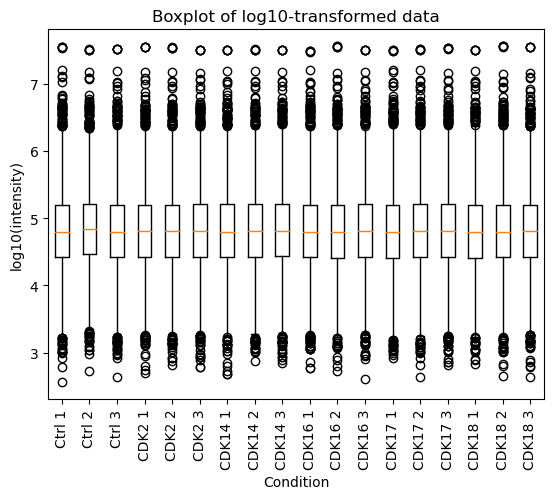

In [11]:
# Now need to do a log-transformation of the data
combined_log = combined.copy()
combined_log[quant_cols_order] = np.log10(combined_log[quant_cols_order] + 1)

# Write the combined_log dataframe to a csv file
combined_log.to_csv(output_folder_path + 'log10_mix_corrected.csv')

plt.boxplot(combined_log[quant_cols_order])
# Use the quant cols order to get the correct names of the labels
plt.xticks(range(1,len(quant_cols_order)+1),quant_cols_order,rotation=90)
plt.ylabel('log10(intensity)')
plt.xlabel('Condition')
plt.title('Boxplot of log10-transformed data')
plt.savefig(output_folder_path + 'log10_boxplot.png',dpi=300)

Found 3 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


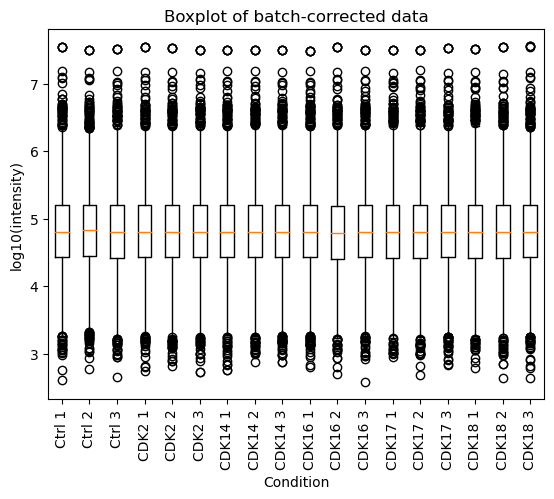

In [12]:
# Now do a batch correction of the data using pycombat

# Make a copy of the combined_zscore dataframe
combined_batch_corrected = combined_log.copy()

combat_data = pycombat(combined_batch_corrected[quant_cols_order],[item.split(' ')[1] for item in quant_cols_order])

# Make a dataframe from the combat_data similar to combined_zscore but with the batch-corrected data instead.
combined_batch_corrected[quant_cols_order] = combat_data

# Write the combined_batch_corrected dataframe to a csv file
combined_batch_corrected.to_csv(output_folder_path + 'log10_mix_batch_corrected.csv')  

plt.boxplot(combined_batch_corrected[quant_cols_order])
# Use the quant cols order to get the correct names of the labels
plt.xticks(range(1,len(quant_cols_order)+1),quant_cols_order,rotation=90)
plt.ylabel('log10(intensity)')
plt.xlabel('Condition')
plt.title('Boxplot of batch-corrected data')
plt.savefig(output_folder_path + 'batch_corrected_boxplot.png',dpi=300)


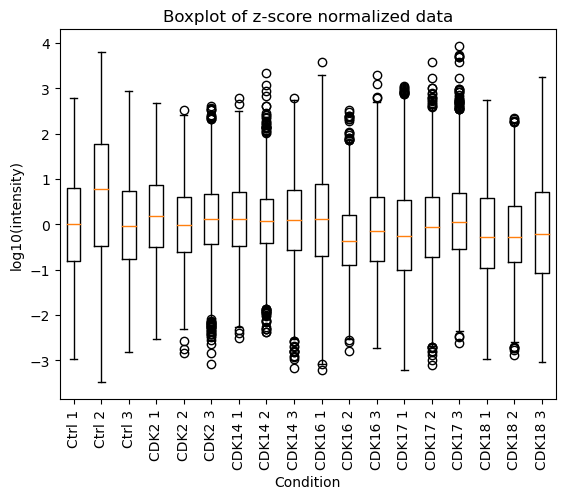

In [13]:
# Now lets z-score normalize the data
combined_zscore = combined_batch_corrected.copy()

# Take the z-score row-wise
combined_zscore[quant_cols_order] = combined_zscore[quant_cols_order].apply(lambda x: (x - np.mean(x)) / np.std(x), axis=1)

# Write the combined dataframe to a csv file
combined_zscore.to_csv(output_folder_path + 'log10_mix_batch_corrected_zscore.csv')

plt.boxplot(combined_zscore[quant_cols_order])
# Use the quant cols order to get the correct names of the labels
plt.xticks(range(1,len(quant_cols_order)+1),quant_cols_order,rotation=90)
plt.ylabel('log10(intensity)')
plt.xlabel('Condition')
plt.title('Boxplot of z-score normalized data')
plt.savefig(output_folder_path + 'zscore_boxplot.png',dpi=300)


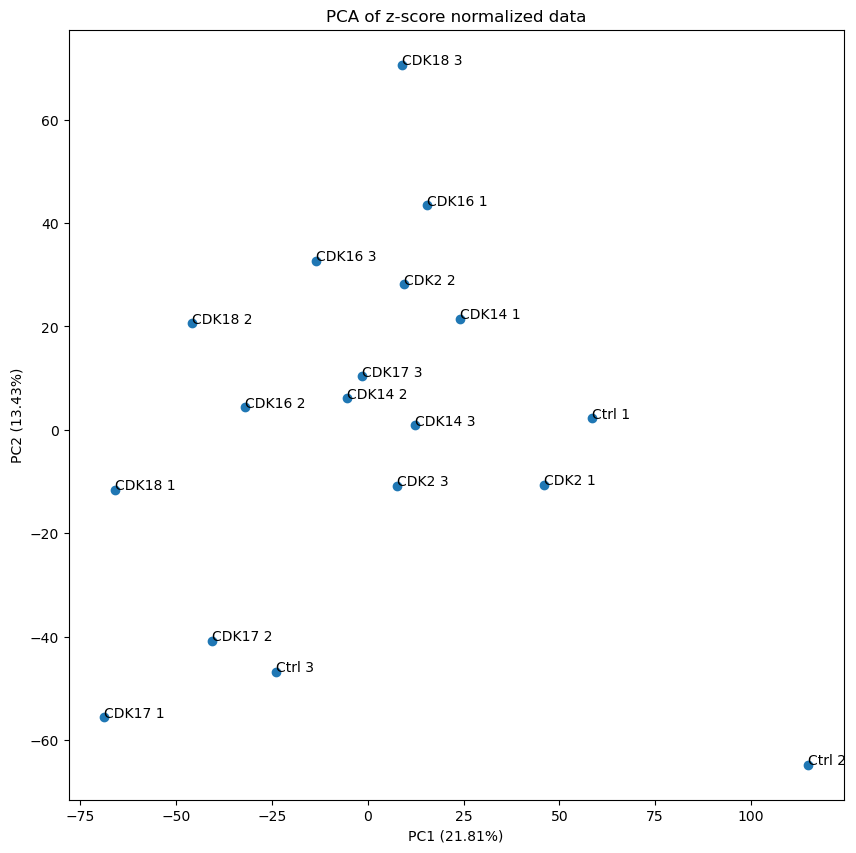

In [17]:
# Make a PCA plot of the z-score normalized data

# Filter the data to only include the quant columns
zscore_quant = combined_zscore[quant_cols_order].dropna()

# Each column should be a point on the PCA plot

# Make a PCA object
pca = PCA(n_components=2)

# Fit the PCA object to the data
pca.fit(zscore_quant.transpose())

# Transform the data
pca_data = pca.transform(zscore_quant.transpose())

# Make a dataframe from the pca_data
pca_df = pd.DataFrame(pca_data, index=quant_cols_order, columns=['PC1','PC2'])

# Plot the PCA data
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(pca_df['PC1'], pca_df['PC2'])

# Add annotations of the points
for i, txt in enumerate(pca_df.index):
    ax.annotate(txt, (pca_df['PC1'][i], pca_df['PC2'][i]))

# In the axes labels include the percent of variance explained by each PC
ax.set_xlabel('PC1 (' + str(round(pca.explained_variance_ratio_[0]*100,2)) + '%)')
ax.set_ylabel('PC2 (' + str(round(pca.explained_variance_ratio_[1]*100,2)) + '%)')
ax.set_title('PCA of z-score normalized data')
fig.savefig(output_folder_path + 'PCA.png')



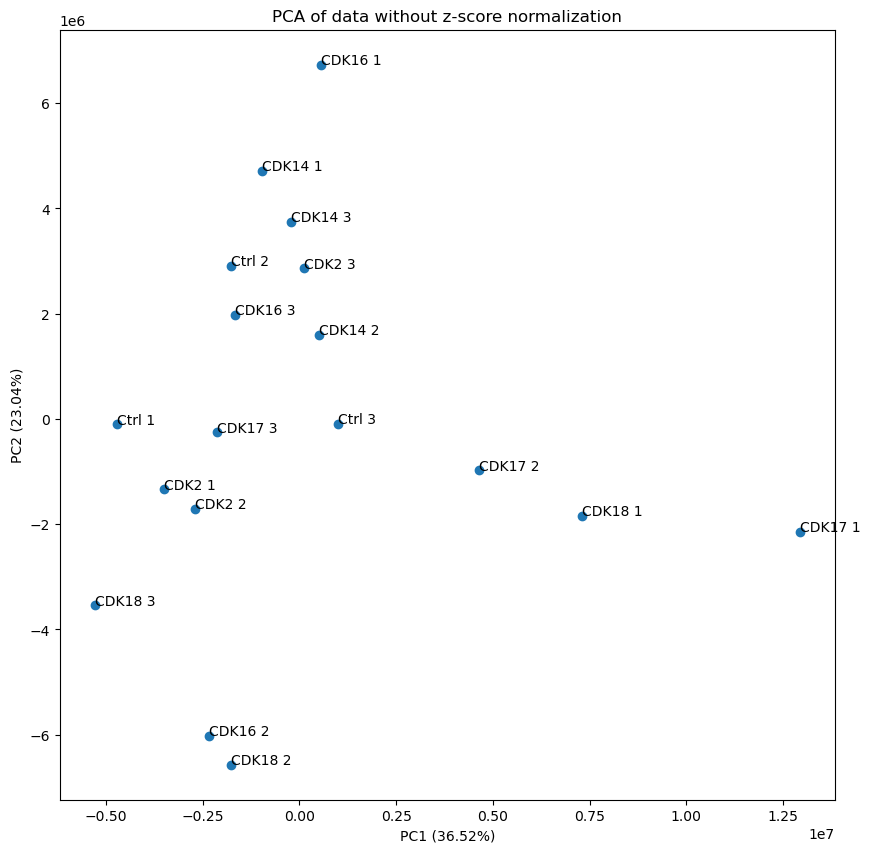

In [18]:
# Filter the data to only include the quant columns
quant_data = combined[quant_cols_order].dropna()

# Create a PCA object
pca = PCA(n_components=2)

# Fit the PCA object to the data
pca.fit(quant_data.transpose())

# Transform the data
pca_data = pca.transform(quant_data.transpose())

# Make a dataframe from the pca_data
pca_df = pd.DataFrame(pca_data, index=quant_cols_order, columns=['PC1', 'PC2'])

# Plot the PCA data
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(pca_df['PC1'], pca_df['PC2'])

# Add annotations of the points
for i, txt in enumerate(pca_df.index):
    ax.annotate(txt, (pca_df['PC1'][i], pca_df['PC2'][i]))

# In the axes labels include the percent of variance explained by each PC
ax.set_xlabel('PC1 (' + str(round(pca.explained_variance_ratio_[0] * 100, 2)) + '%)')
ax.set_ylabel('PC2 (' + str(round(pca.explained_variance_ratio_[1] * 100, 2)) + '%)')
ax.set_title('PCA of data without z-score normalization')
plt.savefig(output_folder_path + 'PCA_no_zscore.png')


In [19]:
# Make a correlation matrix between all of the observations
corr = zscore_quant.transpose().corr()
link = shc.linkage(corr, method='average', metric='euclidean')

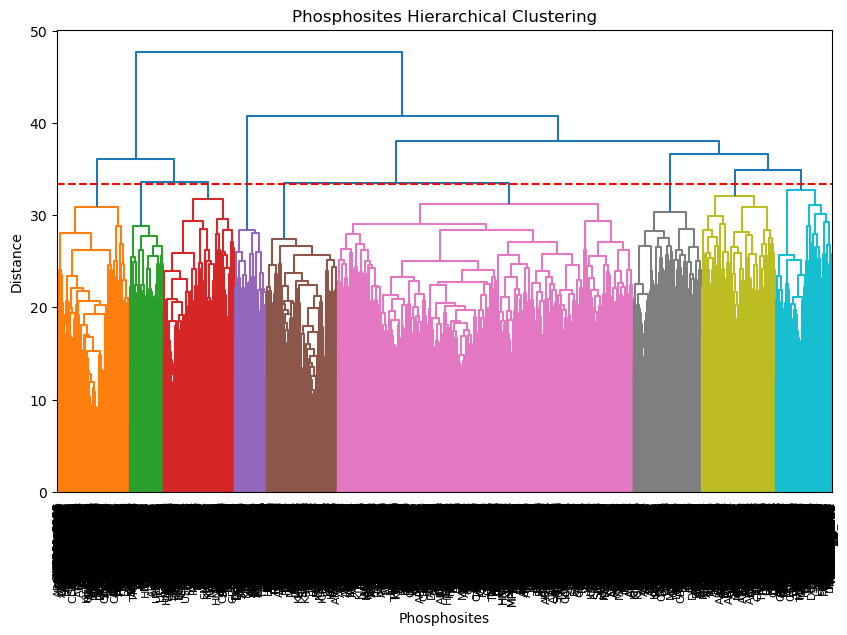

In [20]:
# Create a dendrogram
plt.figure(figsize=(10, 6))
shc.dendrogram(link, labels=corr.index, leaf_rotation=90, leaf_font_size=8)
plt.title('Phosphosites Hierarchical Clustering')
plt.xlabel('Phosphosites')
plt.ylabel('Distance')

# Add a horizontal line at y=35
plt.axhline(y=0.7*max(link[:,2]), color='r', linestyle='--')

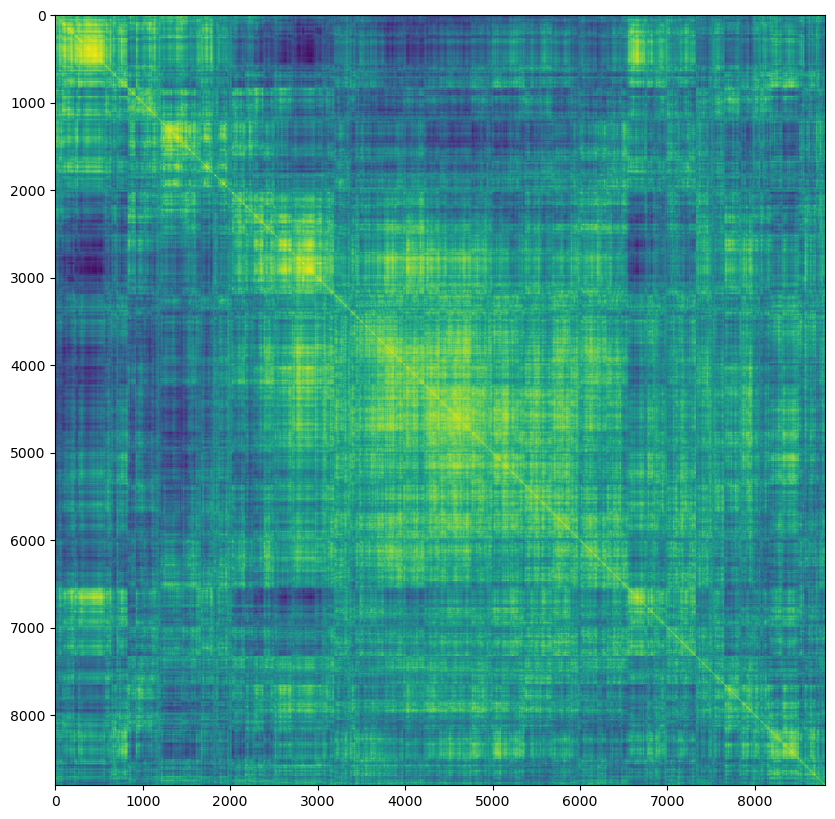

In [21]:
threshold_height = 0.7*max(link[:,2])
corr_clusters = shc.fcluster(link, threshold_height, criterion='distance')

# Get the ordering of the dendrogram leaves
sorted_indices = shc.dendrogram(link, no_plot=True)['leaves']

# Sort the correlation matrix by the dendrogram ordering. Corr is a pandas dataframe so we can use the .values attribute to get the underlying numpy array
sorted_correlation_matrix = corr.iloc[sorted_indices, sorted_indices]

# Visualize the sorted correlation matrix
plt.figure(figsize=(10, 10))
plt.imshow(sorted_correlation_matrix.values, cmap='viridis')



In [22]:
# Compute log2 fold changes from the batch corrected data.

# Make a copy of the combined_batch_corrected dataframe
combined_batch_corrected_log2 = combined_batch_corrected.copy()

# First I need to convert the log10 intensities back to linear intensities
combined_batch_corrected_log2[quant_cols_order] = 10**combined_batch_corrected_log2[quant_cols_order] - 1 # -1 is to undo the +1 in the log10 transformation

# Now convert these to log2 intensities
combined_batch_corrected_log2[quant_cols_order] = np.log2(combined_batch_corrected_log2[quant_cols_order] + 1)

# Need to make this general using a dict of comparisons

comparisons = {
    'CDK2':[['Ctrl 1','Ctrl 2','Ctrl 3'],['CDK2 1','CDK2 2','CDK2 3']],
    'CDK14':[['Ctrl 1','Ctrl 2','Ctrl 3'],['CDK14 1','CDK14 2','CDK14 3']],
    'CDK16':[['Ctrl 1','Ctrl 2','Ctrl 3'],['CDK16 1','CDK16 2','CDK16 3']],
    'CDK17':[['Ctrl 1','Ctrl 2','Ctrl 3'],['CDK17 1','CDK17 2','CDK17 3']],
    'CDK18':[['Ctrl 1','Ctrl 2','Ctrl 3'],['CDK18 1','CDK18 2','CDK18 3']]
}

# Compute the log2 fold changes for each comparison
for key in comparisons.keys():
    if len(comparisons[key][0]) == len(comparisons[key][1]):
        print(key + ': Same length. Using mean log2 fold change of samples.')
        fc_list = []
        ctrl_vals = []
        test_vals = []
        for i in range(len(comparisons[key][0])):
            ctrl_vals.append(combined_batch_corrected_log2[comparisons[key][0][i]])
            test_vals.append(combined_batch_corrected_log2[comparisons[key][1][i]])
            fc_list.append(combined_batch_corrected_log2[comparisons[key][1][i]] - combined_batch_corrected_log2[comparisons[key][0][i]])
        combined_batch_corrected_log2['log2FC_' + key] = np.mean(fc_list,axis=0)
        # Perform the t-test
        ttest = ttest_rel(ctrl_vals,test_vals,axis=0)
        combined_batch_corrected_log2['pval_' + key] = ttest.pvalue
    else:
        print(key + ': Different length. Using log2 fold change of means.')
        # Use the log2 fold change of the means
        combined_batch_corrected_log2['log2FC_' + key] = np.mean(combined_batch_corrected_log2[comparisons[key][1]],axis=1) - np.mean(combined_batch_corrected_log2[comparisons[key][0]],axis=1)
        
        # Perform the t-test
        ttest = ttest_ind(combined_batch_corrected_log2[comparisons[key][1]],combined_batch_corrected_log2[comparisons[key][0]],axis=1)
        combined_batch_corrected_log2['pval_' + key] = ttest.pvalue

# Now compute the p-values for each comparison
# Use a t-test for each comparison

# Save the combined_batch_corrected_log2 dataframe to a csv file
combined_batch_corrected_log2.to_csv(output_folder_path + 'log2_mix_batch_corrected_tests.csv')

CDK2: Same length. Using mean log2 fold change of samples.
CDK14: Same length. Using mean log2 fold change of samples.
CDK16: Same length. Using mean log2 fold change of samples.
CDK17: Same length. Using mean log2 fold change of samples.
CDK18: Same length. Using mean log2 fold change of samples.


In [23]:
# Now add the p-values and log2 fold changes to the zscore dataframe
combined_zscore_with_fc = combined_zscore.copy()

for key in comparisons.keys():
    combined_zscore_with_fc['log2FC_' + key] = combined_batch_corrected_log2['log2FC_' + key]
    combined_zscore_with_fc['pval_' + key] = combined_batch_corrected_log2['pval_' + key]

# Now add the cluster labels to the dataframe
combined_zscore_with_fc['cluster'] = corr_clusters

# Save the combined_zscore_with_fc dataframe to a csv file
combined_zscore_with_fc.to_csv(output_folder_path + 'combined.csv')

In [24]:
# Create outputs that can be used for enrichment analysis by the kinase library

for key in comparisons.keys():
    df = combined_zscore_with_fc[['Sequence window','log2FC_' + key,'pval_' + key]]    
    # Change the sequence window column to only include the first element ';' of the delimited string
    df['Sequence window'] = df['Sequence window'].apply(lambda x: x.split(';')[0])
    df.to_csv(output_folder_path + key + '_enrichment_input.txt', sep = '\t', index=False)

C:\Users\plutzer\AppData\Local\Temp\ipykernel_20708\4007555337.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sequence window'] = df['Sequence window'].apply(lambda x: x.split(';')[0])
C:\Users\plutzer\AppData\Local\Temp\ipykernel_20708\4007555337.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sequence window'] = df['Sequence window'].apply(lambda x: x.split(';')[0])
C:\Users\plutzer\AppData\Local\Temp\ipykernel_20708\4007555337.py:6: SettingWithCopyWarning: 
A value is trying to be set on

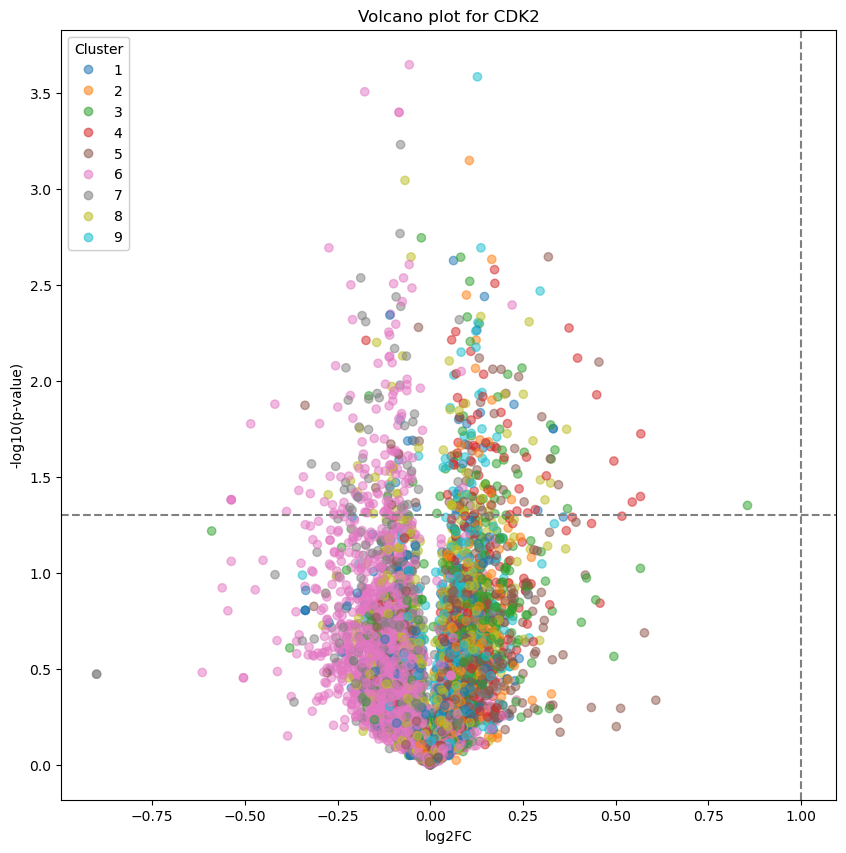

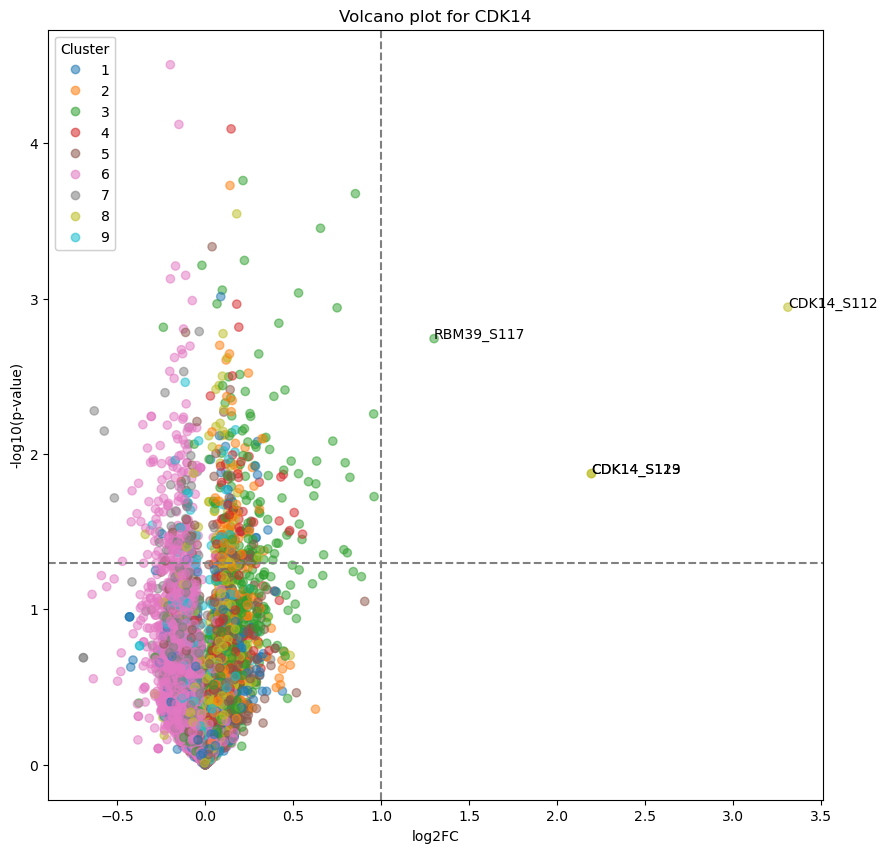

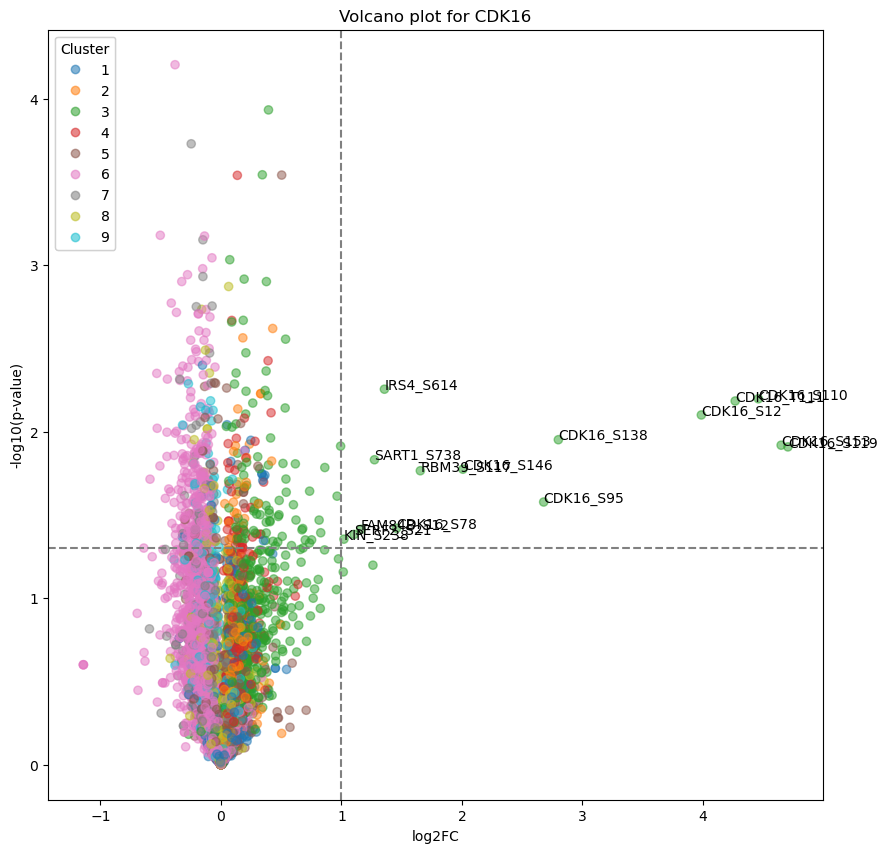

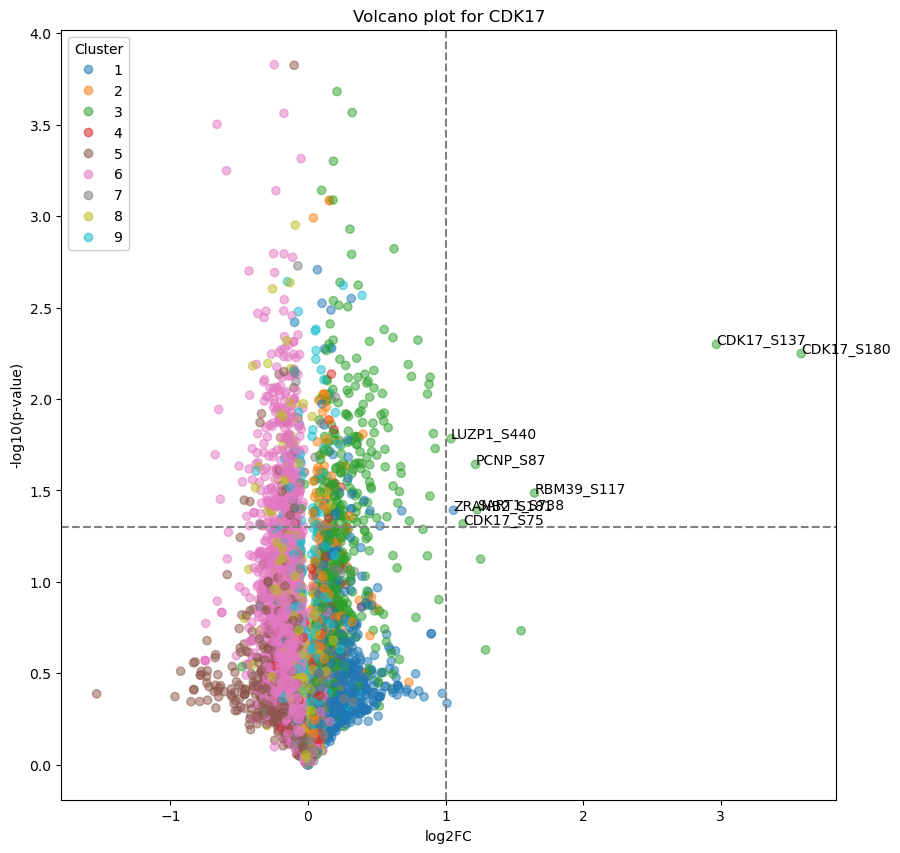

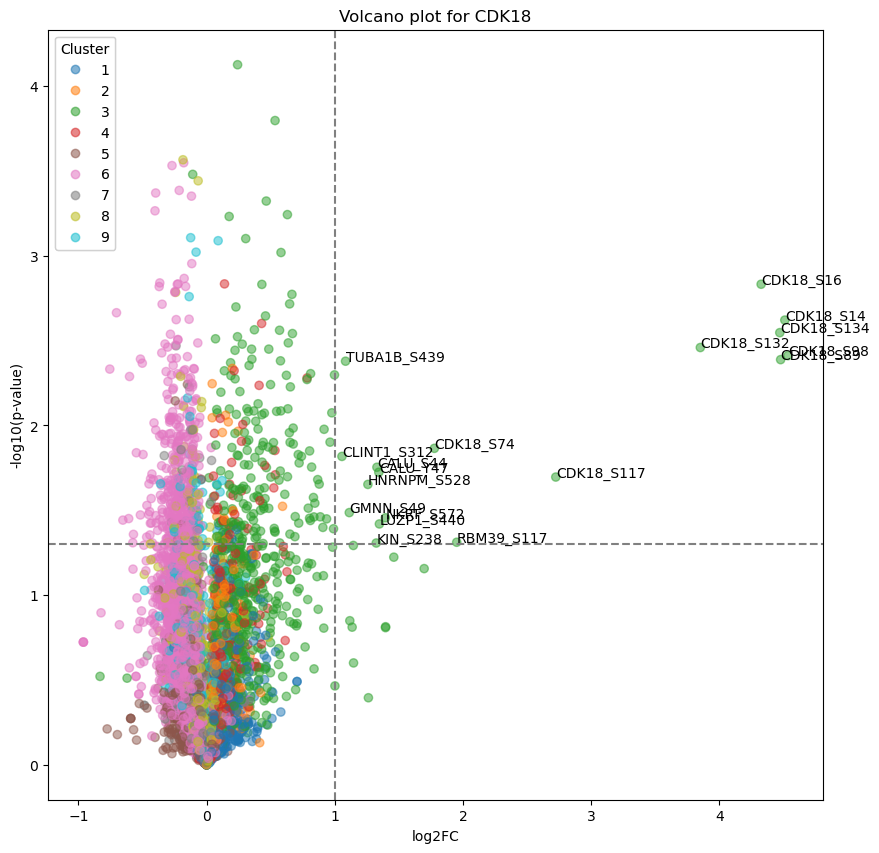

In [34]:
# Create volcano plots for each comparison

for key in comparisons.keys():
    # Make a volcano plot
    fig, ax = plt.subplots(figsize=(10,10))
    # Use default colors for the clusters
    # Color the points on the volcano plot by cluster - use  the colors list
    # Don't do it with the for loop because it affects the order of the points
    scatter = ax.scatter(combined_zscore_with_fc['log2FC_' + key], -np.log10(combined_zscore_with_fc['pval_' + key]), c=combined_zscore_with_fc['cluster'], cmap='tab10', alpha=0.5)

    
    # Add a line for a significance threshold
    ax.axhline(y=-np.log10(0.05), color='grey', linestyle='--')

    # Add a vertical line for the log2FC threshold of 1
    ax.axvline(x=1, color='grey', linestyle='--')

    legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="Cluster")
    ax.add_artist(legend1)

    # Add text annotations for all points that are significant and have a log2FC greater than 1
    for i, txt in enumerate(combined_zscore_with_fc.index):
        if combined_zscore_with_fc['pval_' + key][i] < 0.05 and combined_zscore_with_fc['log2FC_' + key][i] > 1:
            ax.annotate(txt, (combined_zscore_with_fc['log2FC_' + key][i], -np.log10(combined_zscore_with_fc['pval_' + key][i])))

    ax.set_xlabel('log2FC')
    ax.set_ylabel('-log10(p-value)')
    ax.set_title('Volcano plot for ' + key)
    fig.savefig(output_folder_path + key + '_volcano.png')

C:\Users\plutzer\AppData\Local\Temp\ipykernel_20708\386618812.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10,10))


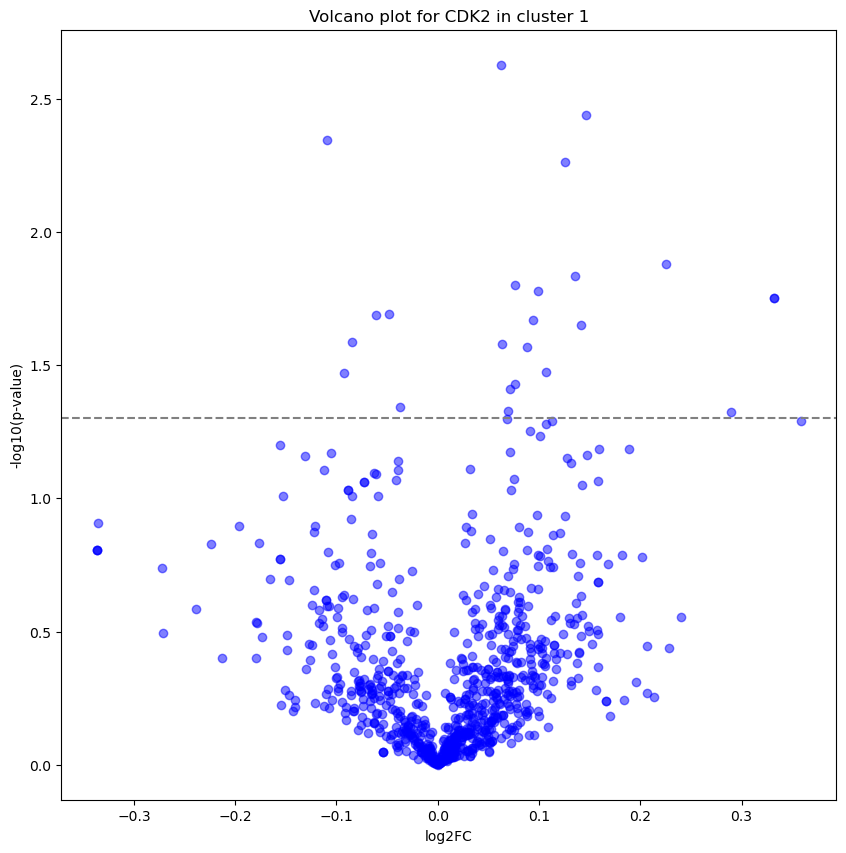

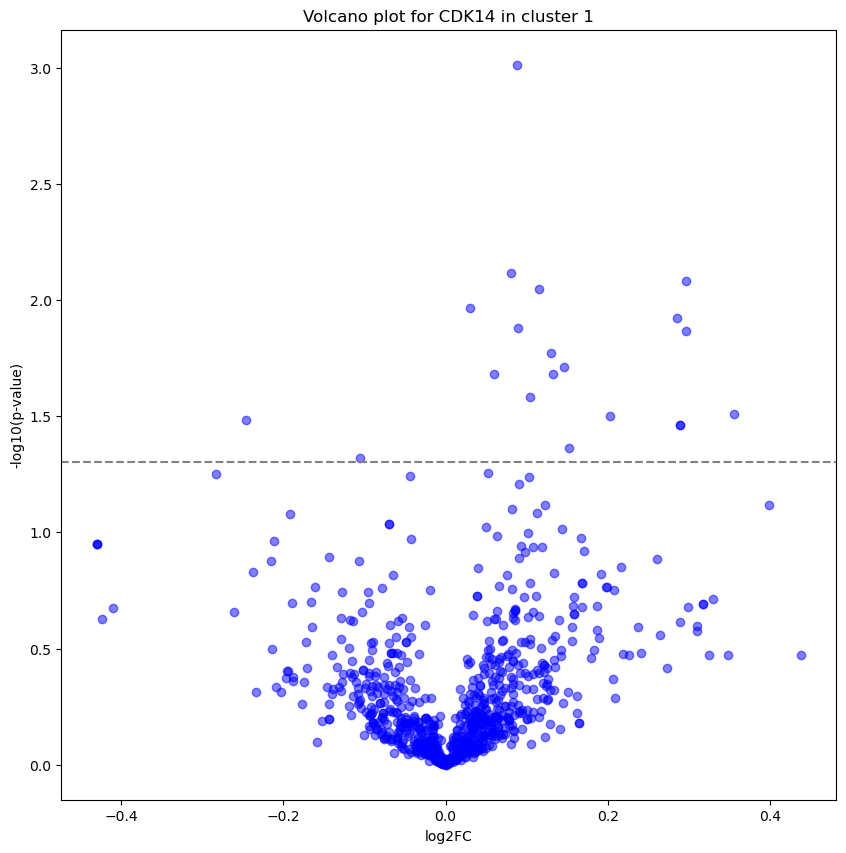

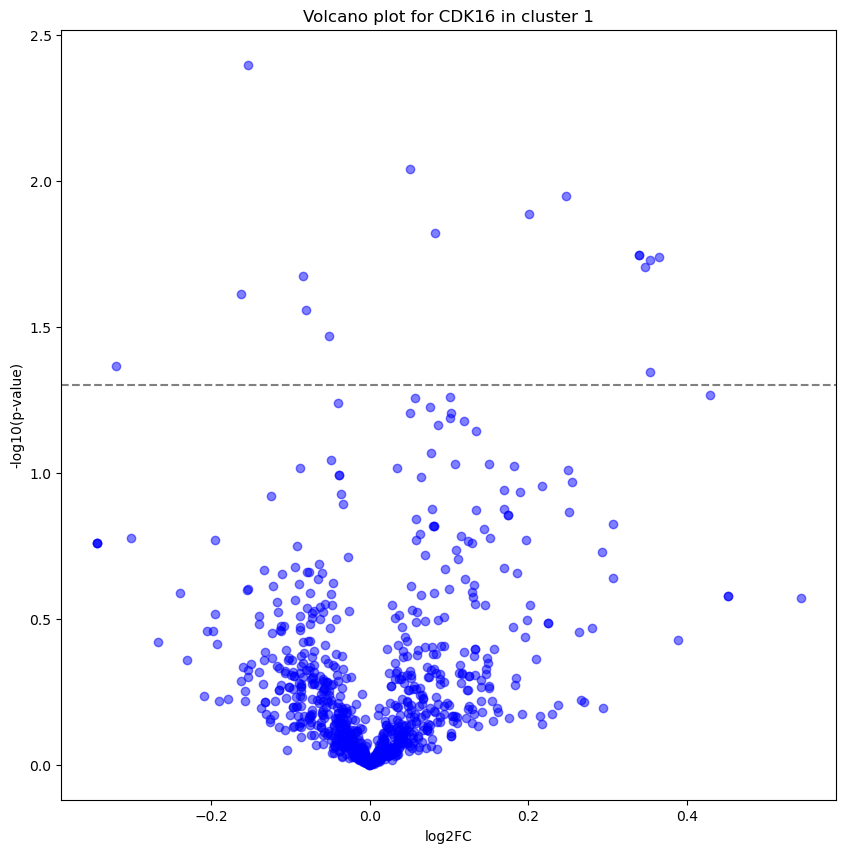

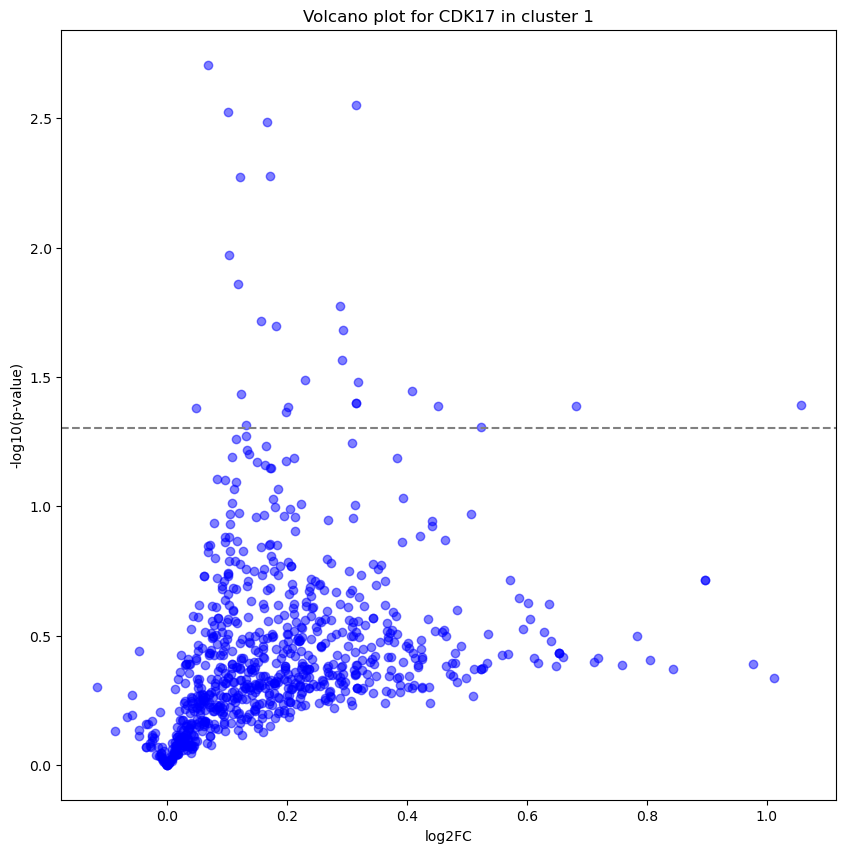

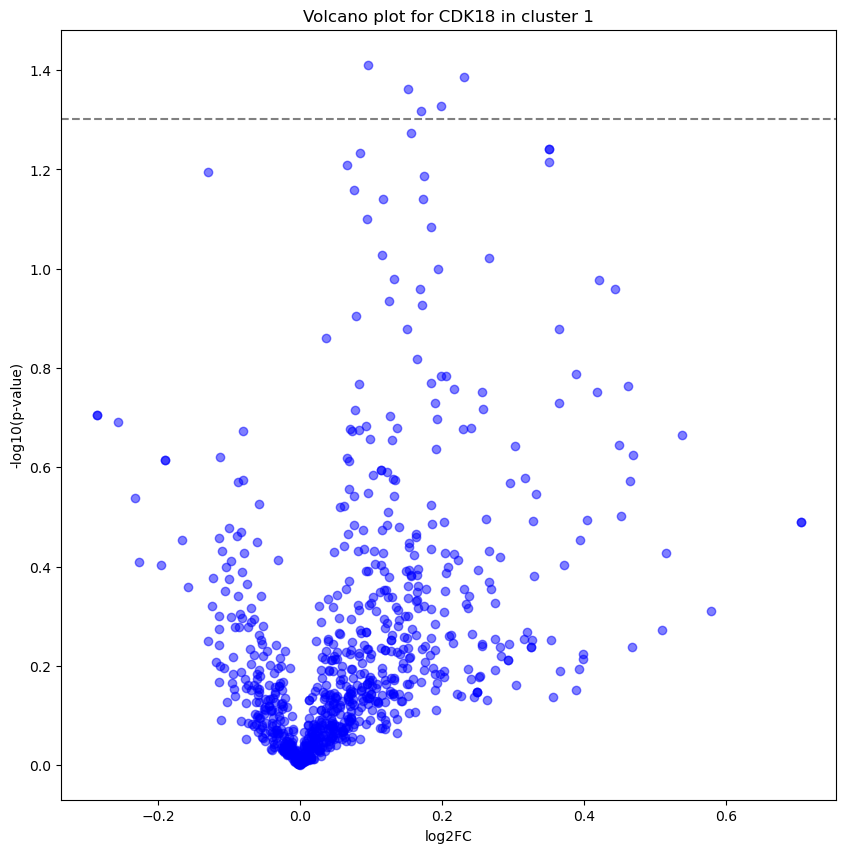

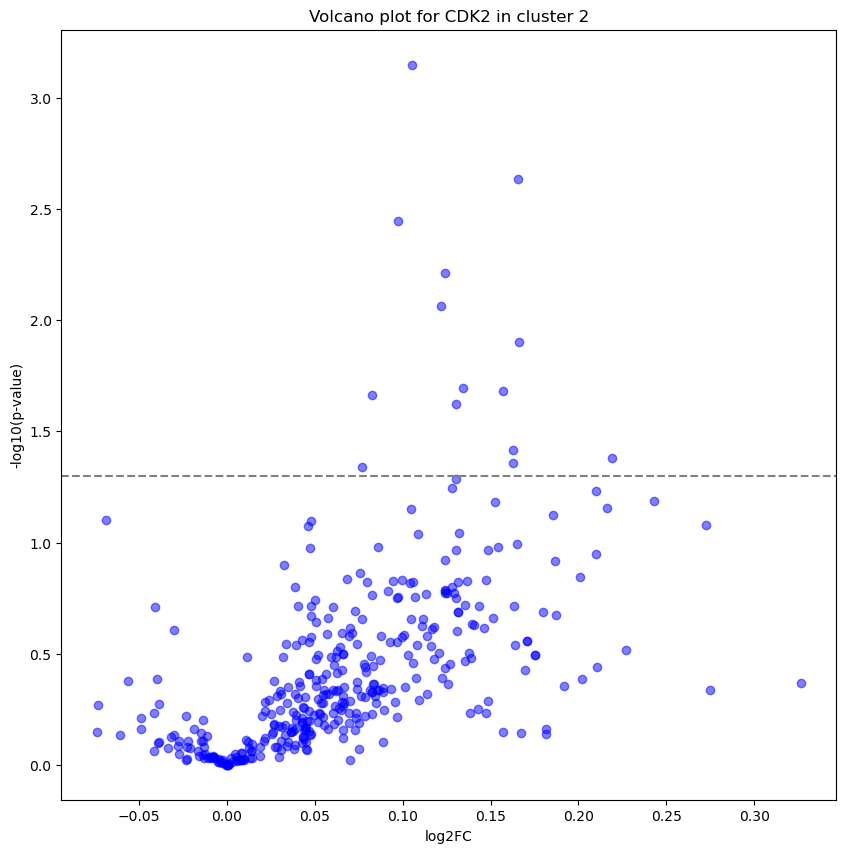

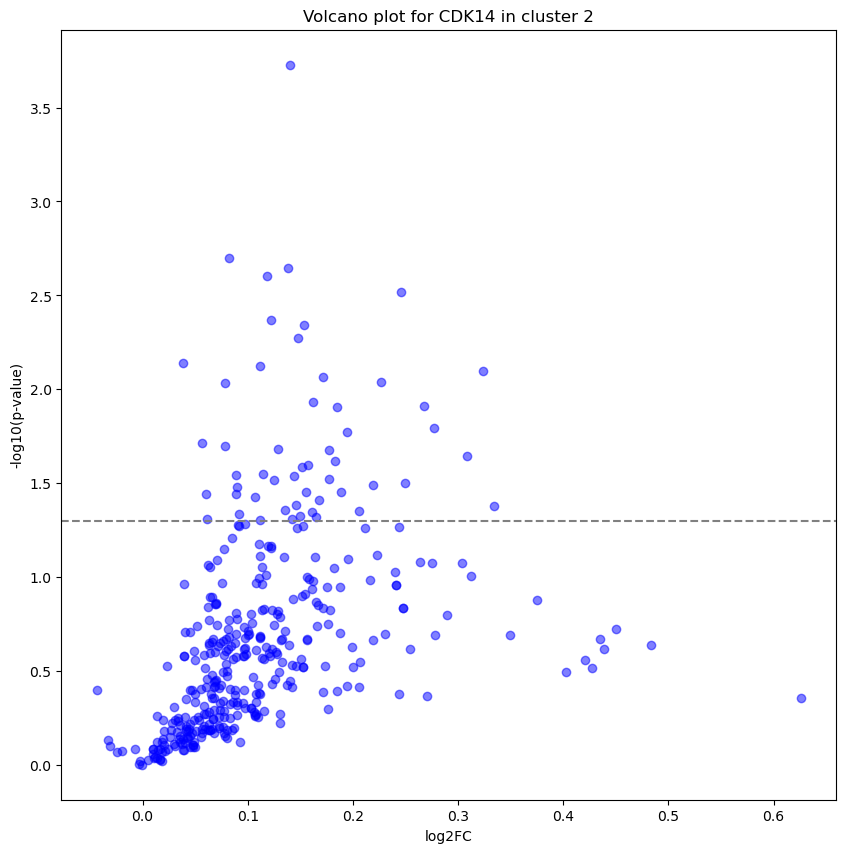

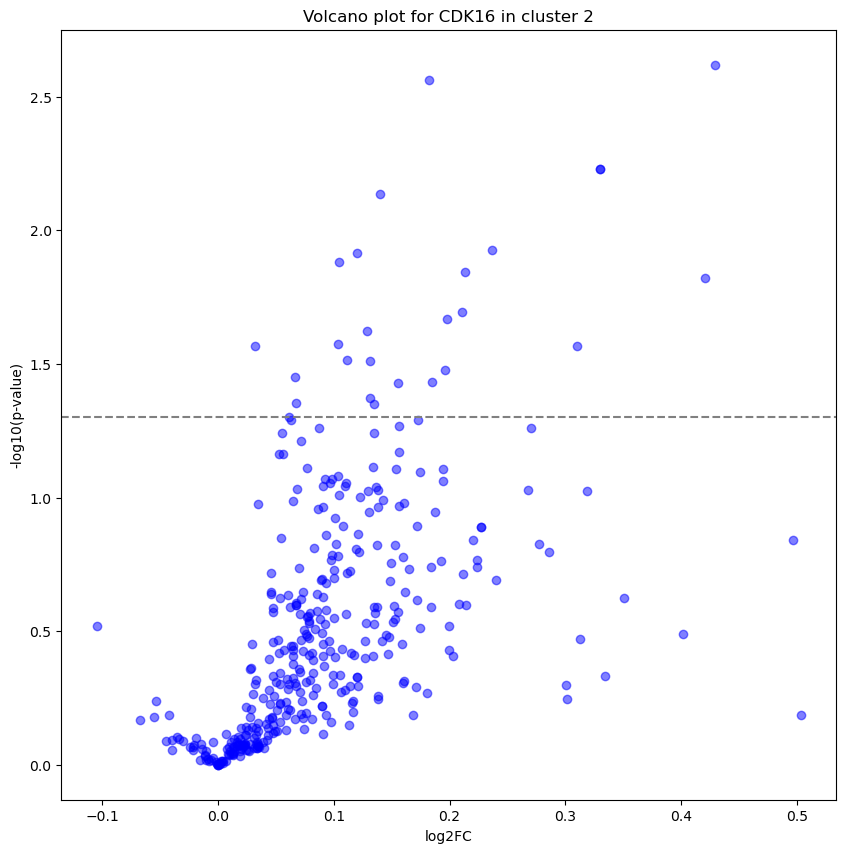

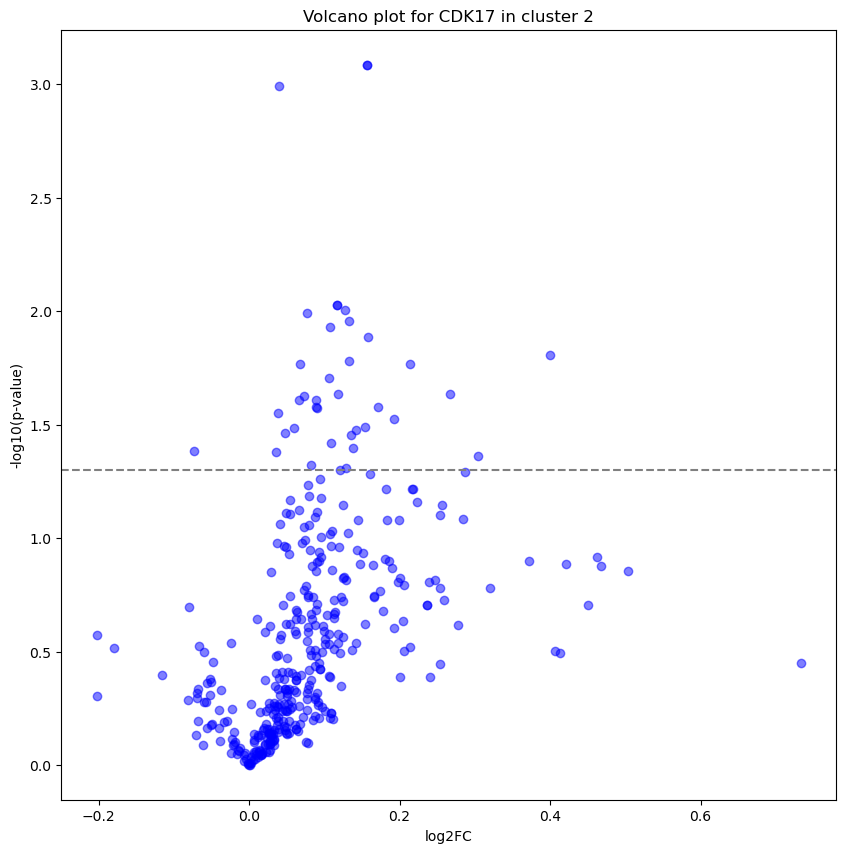

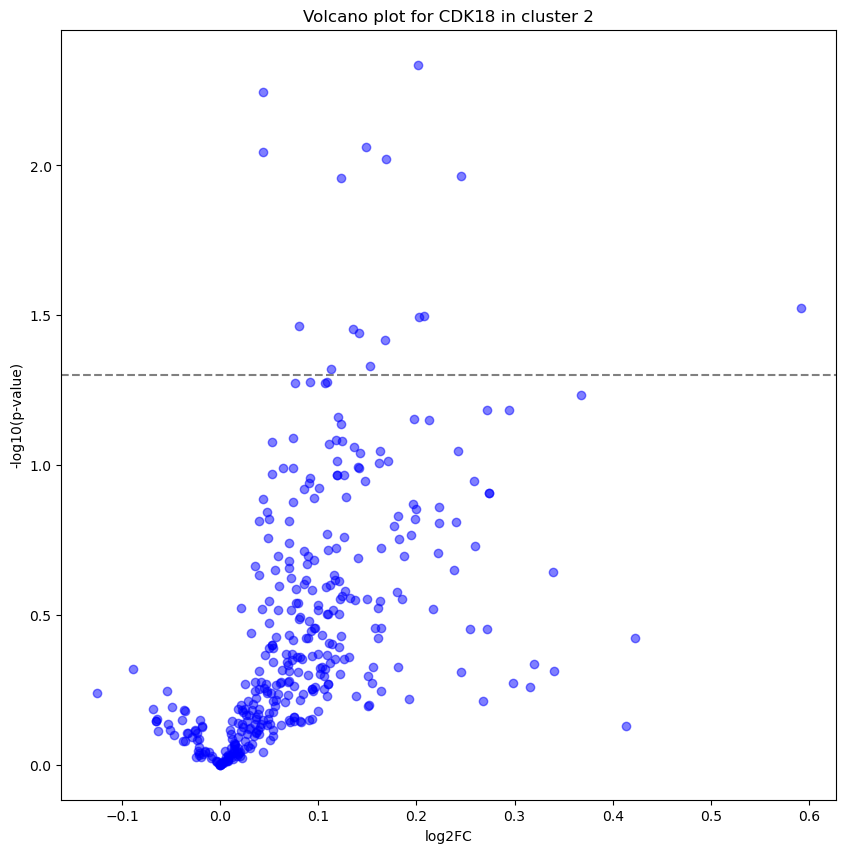

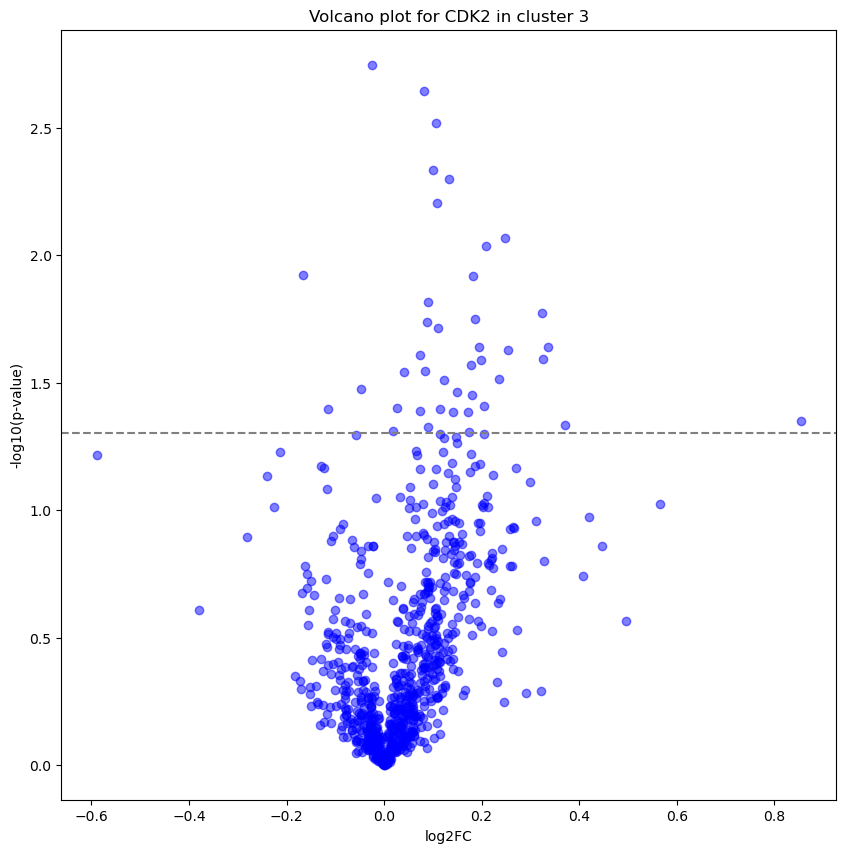

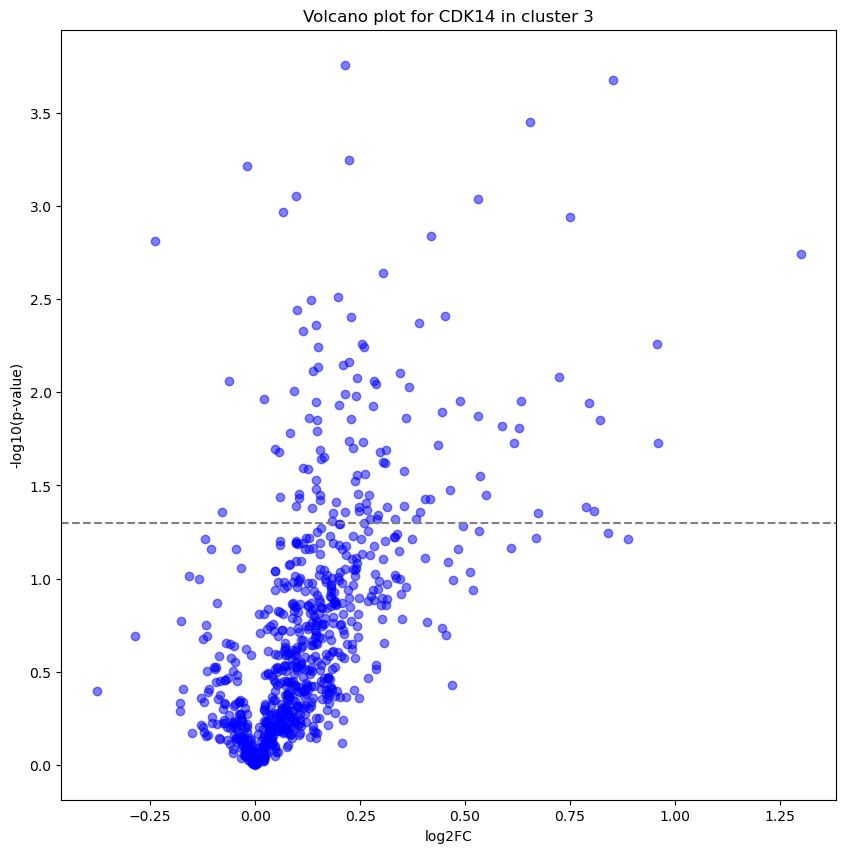

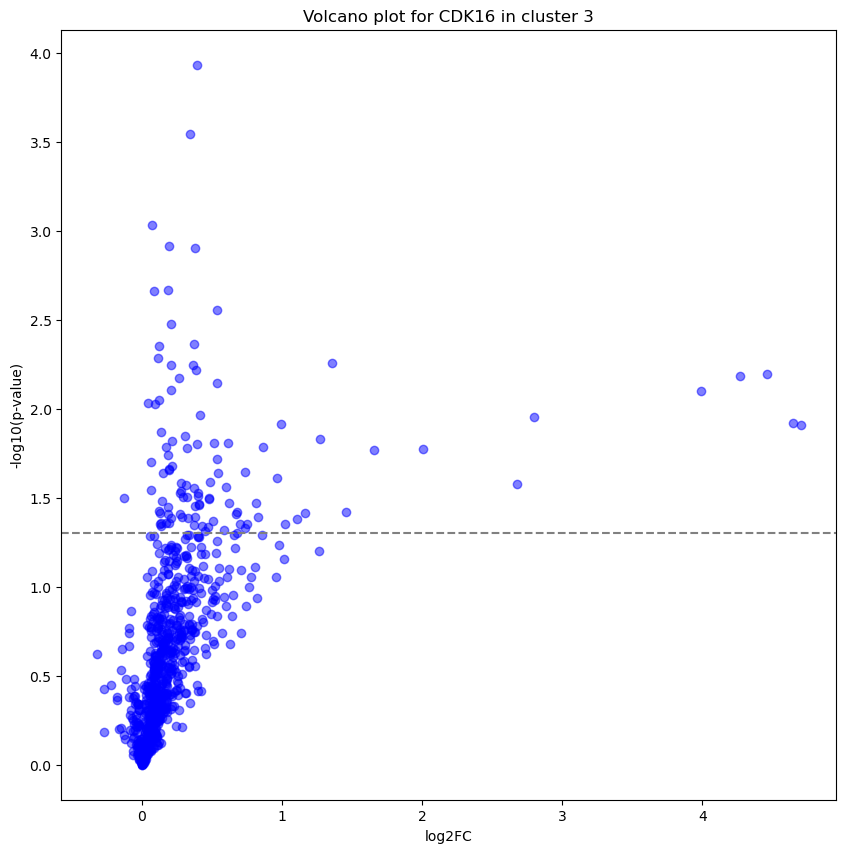

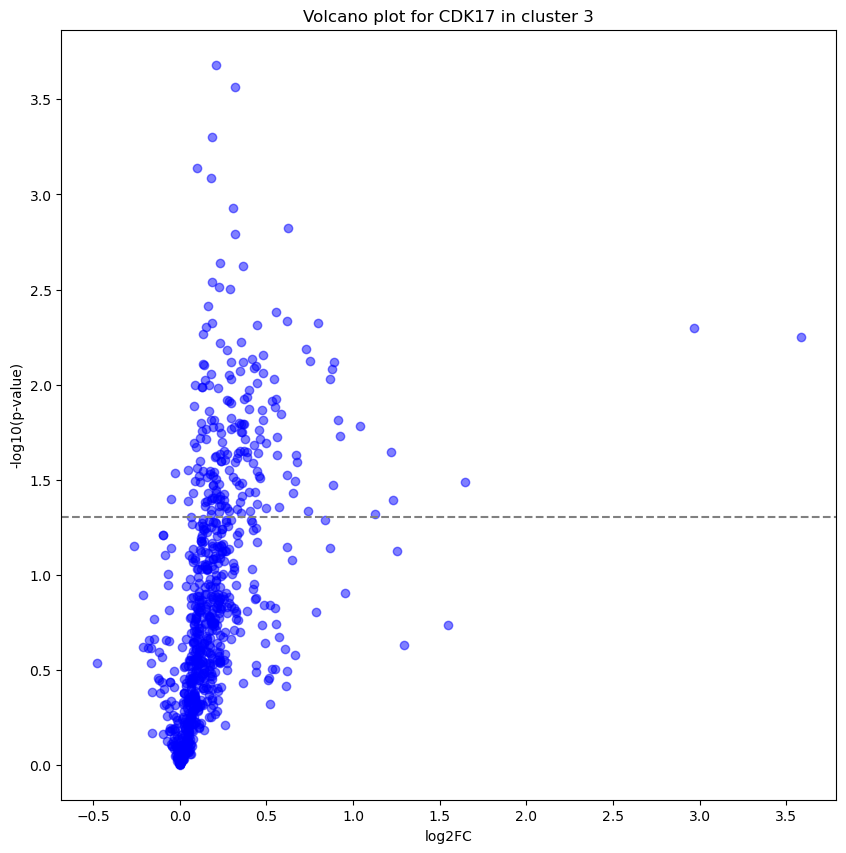

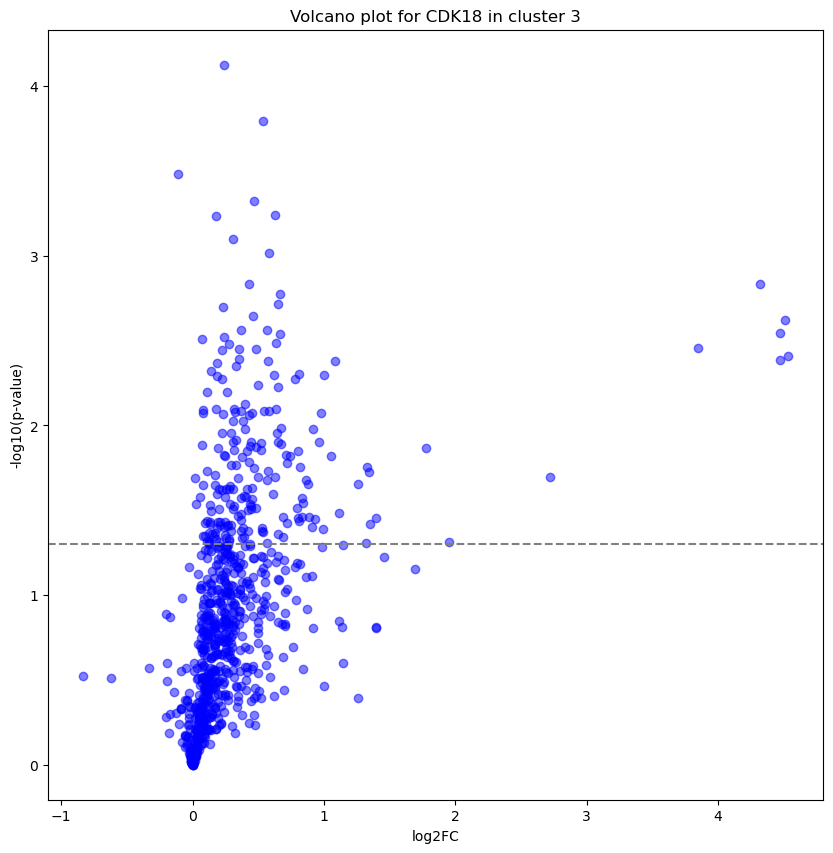

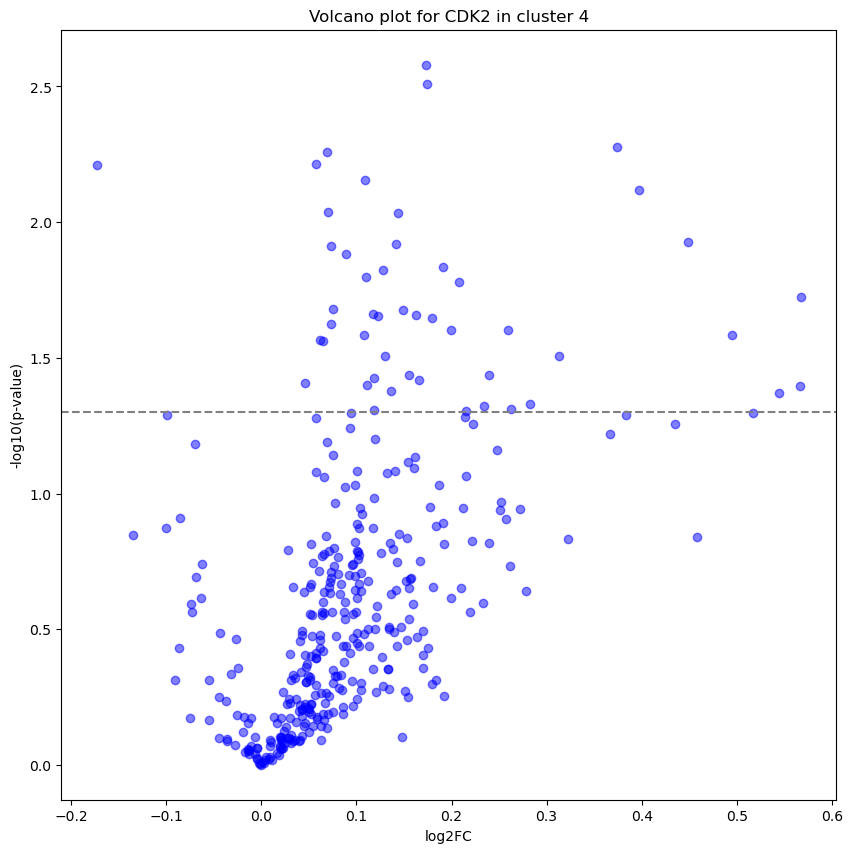

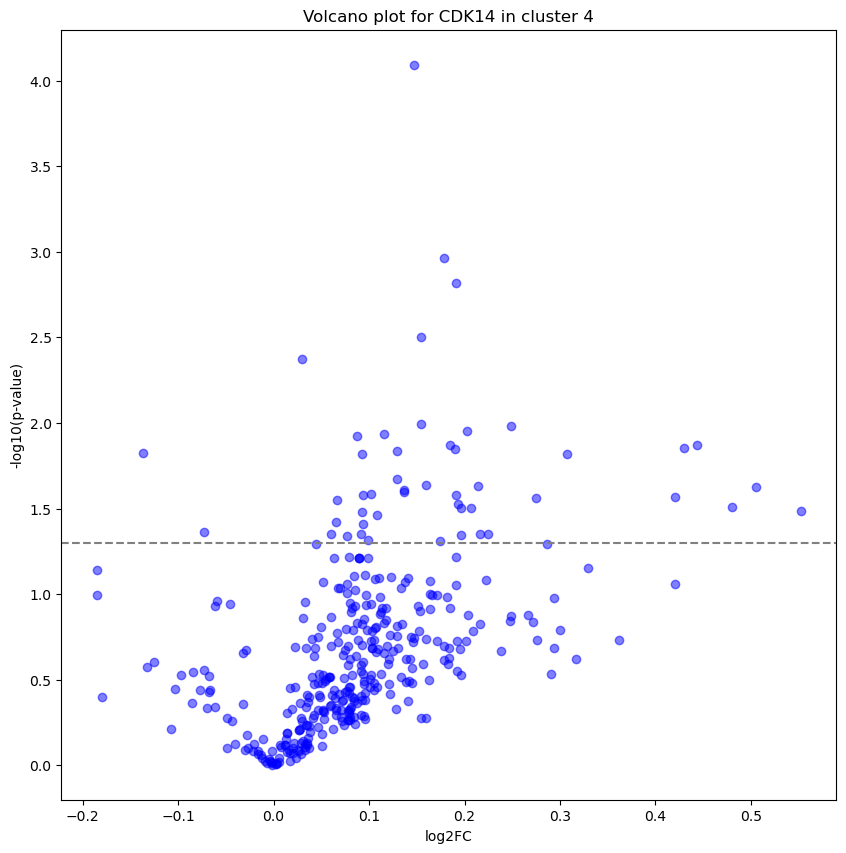

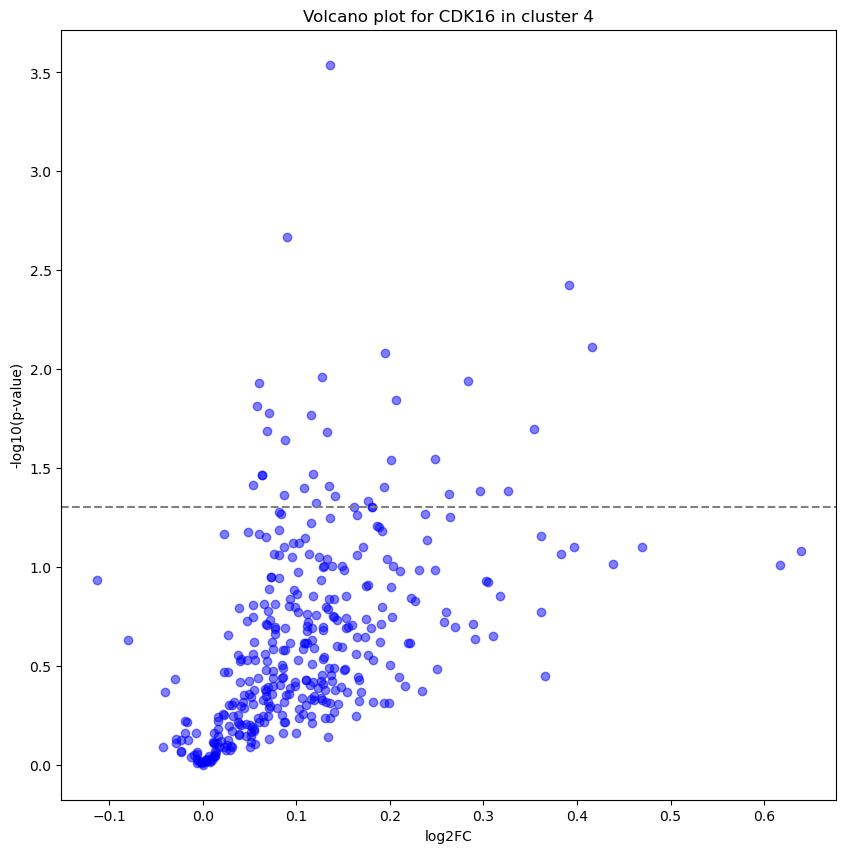

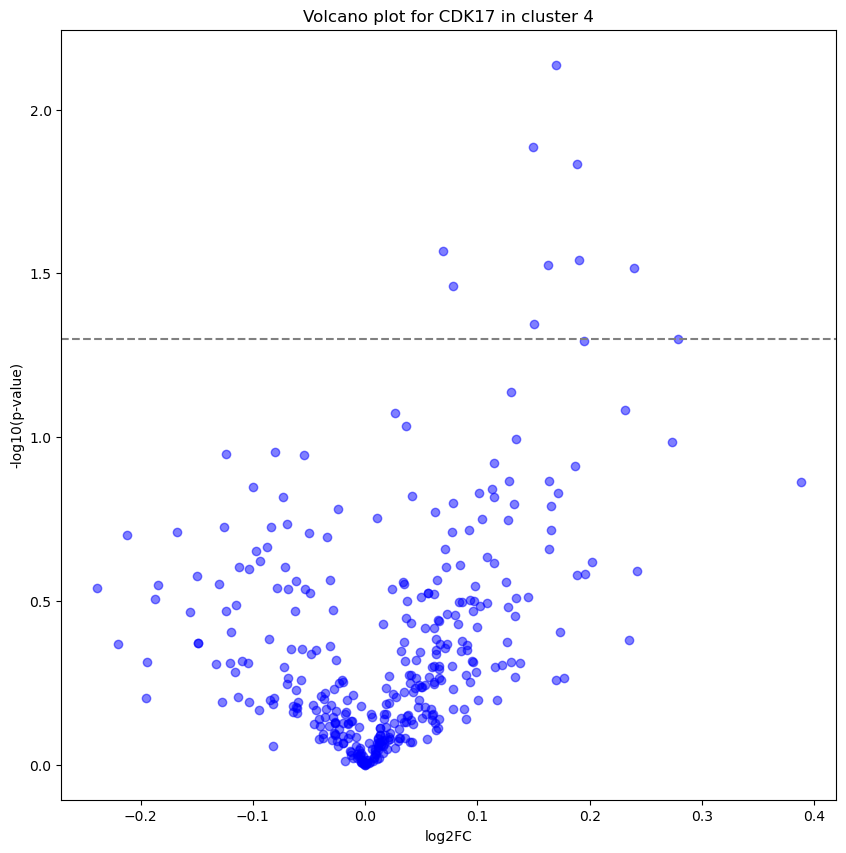

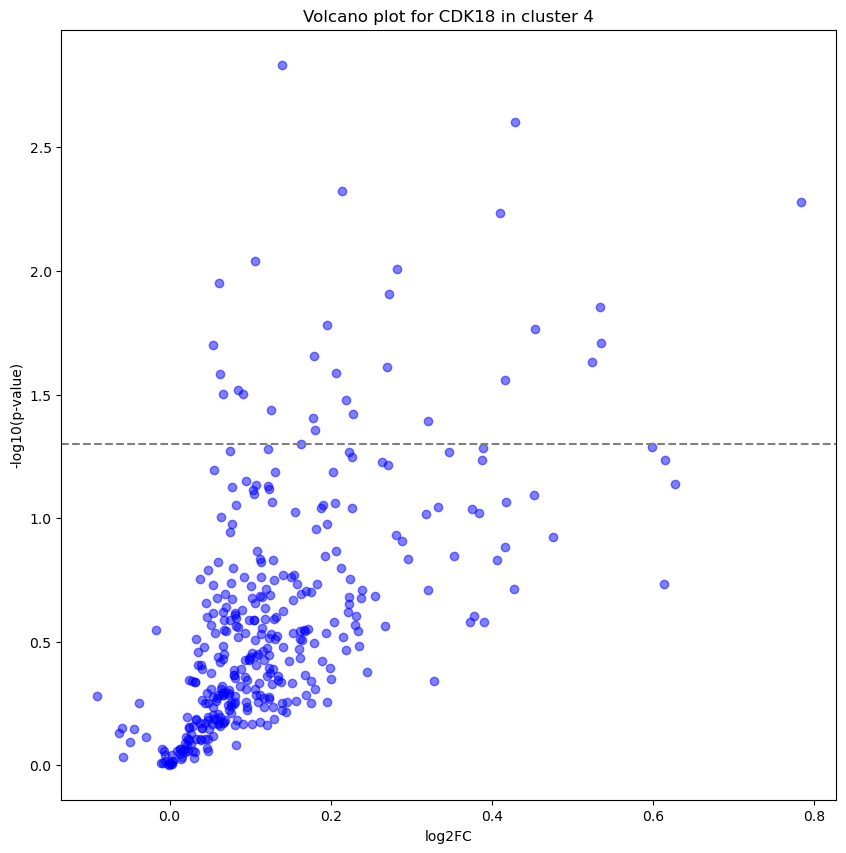

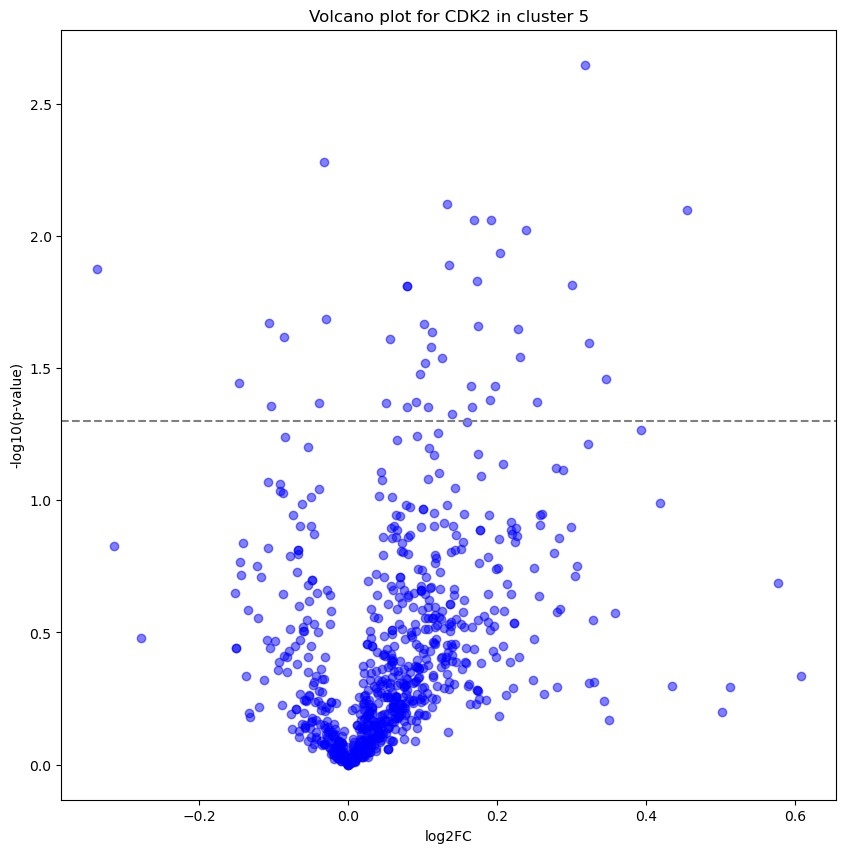

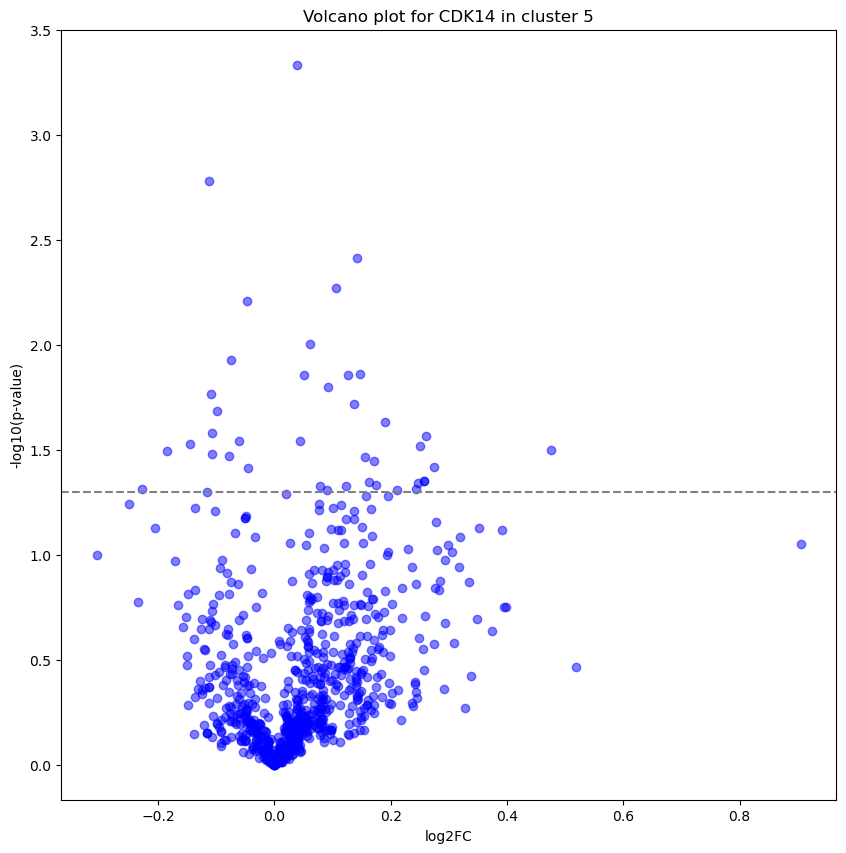

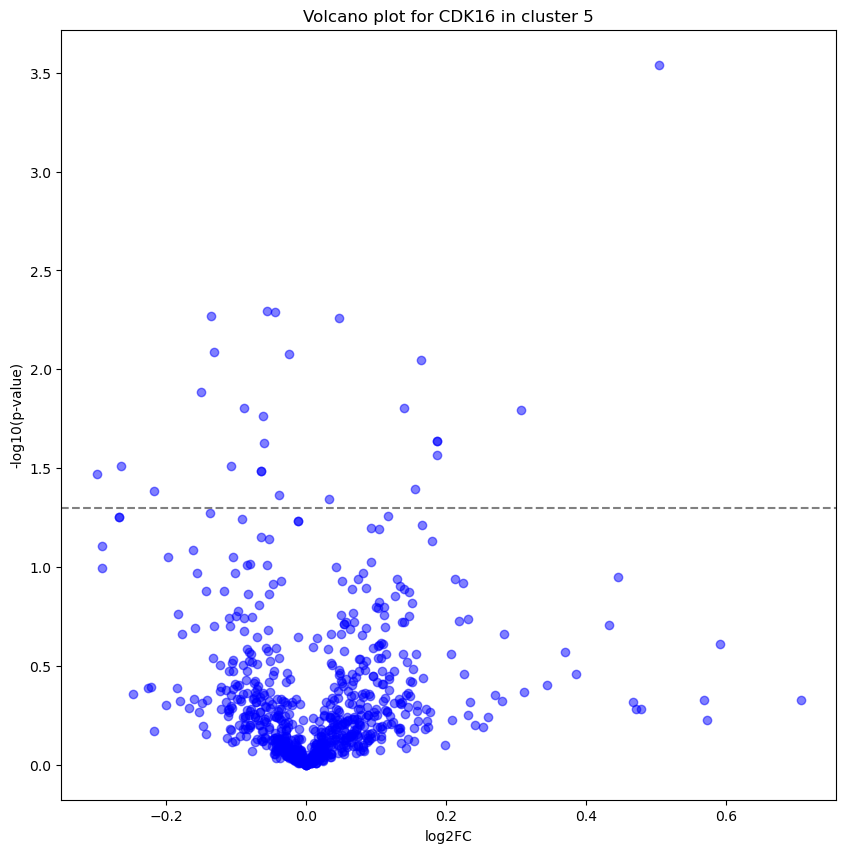

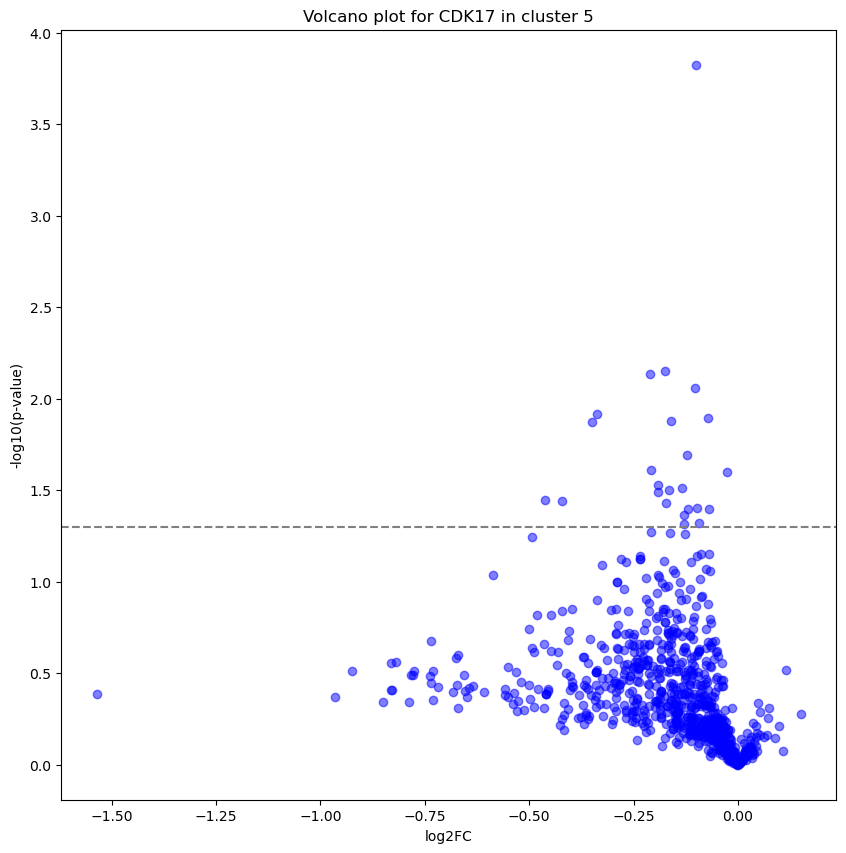

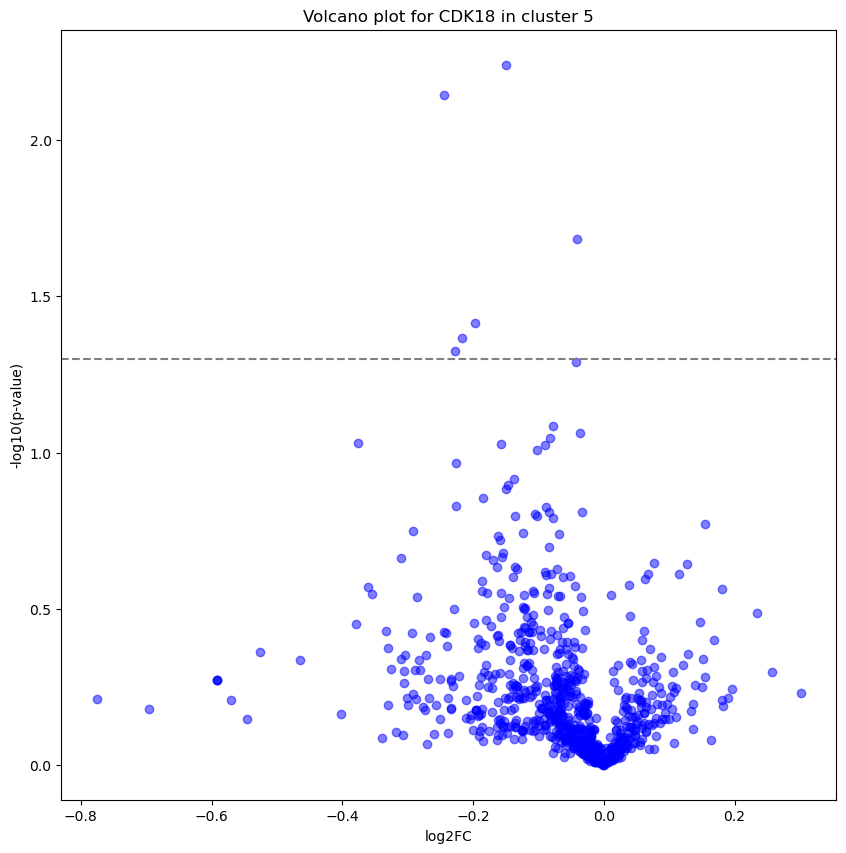

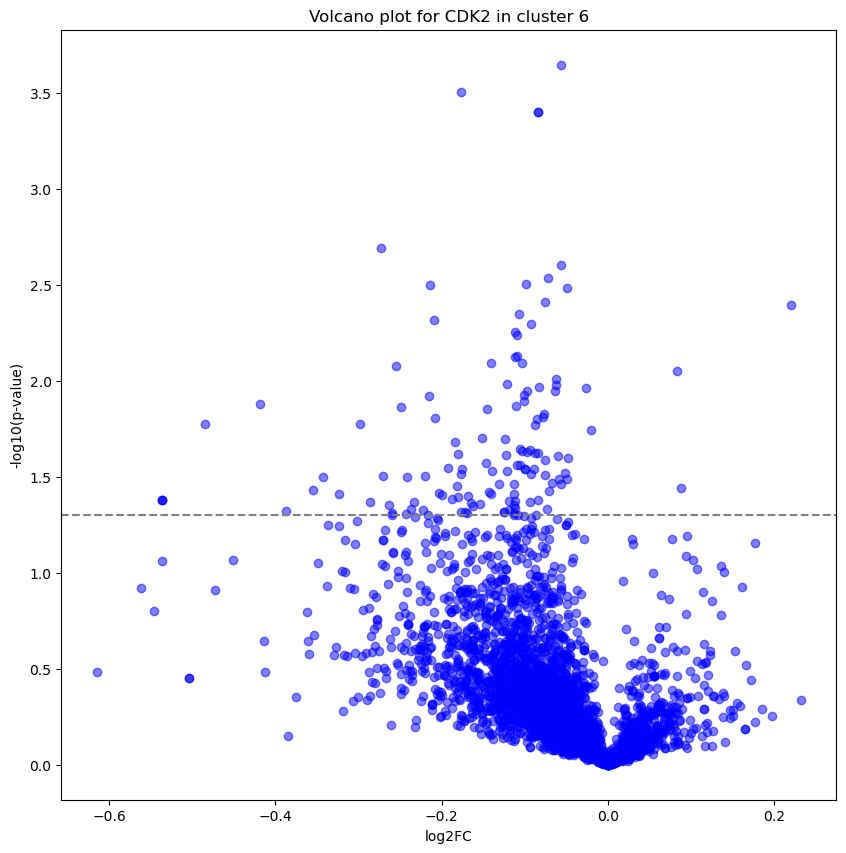

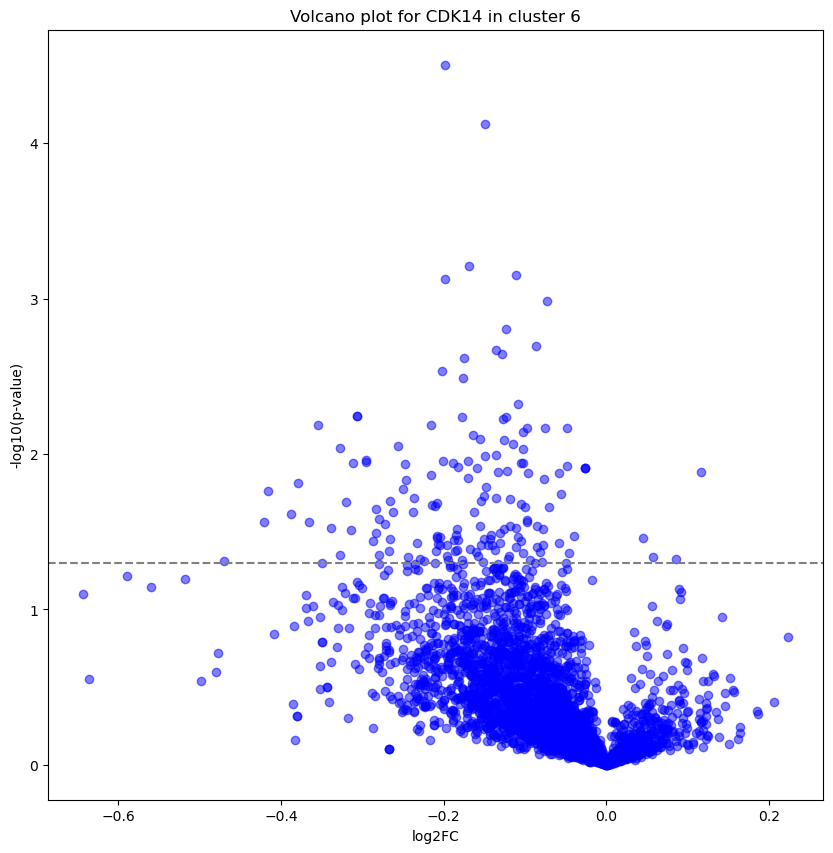

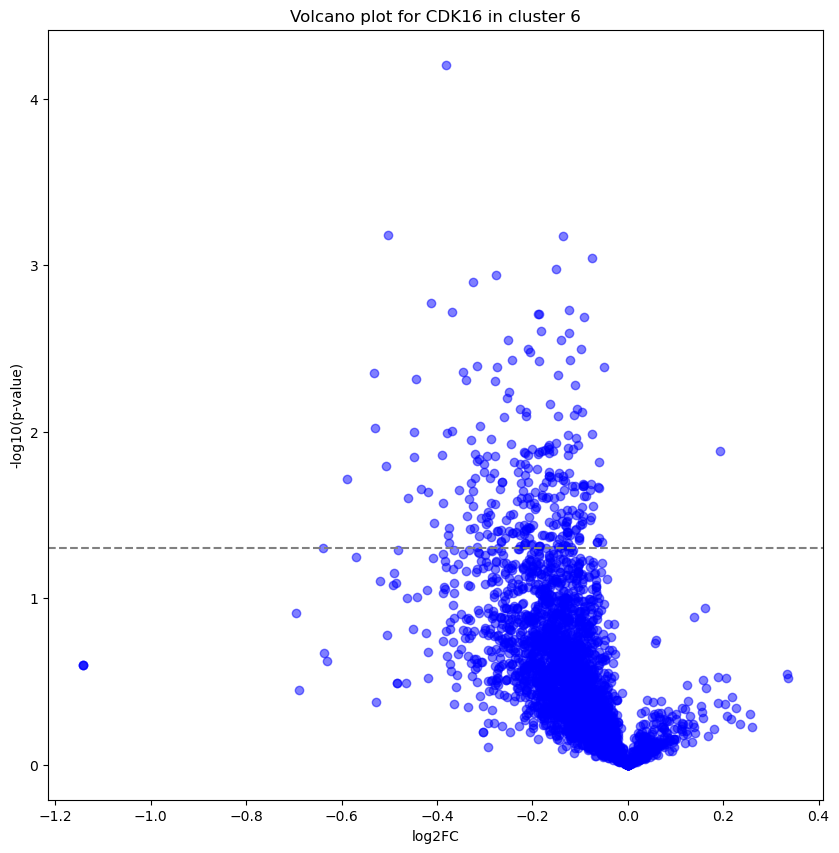

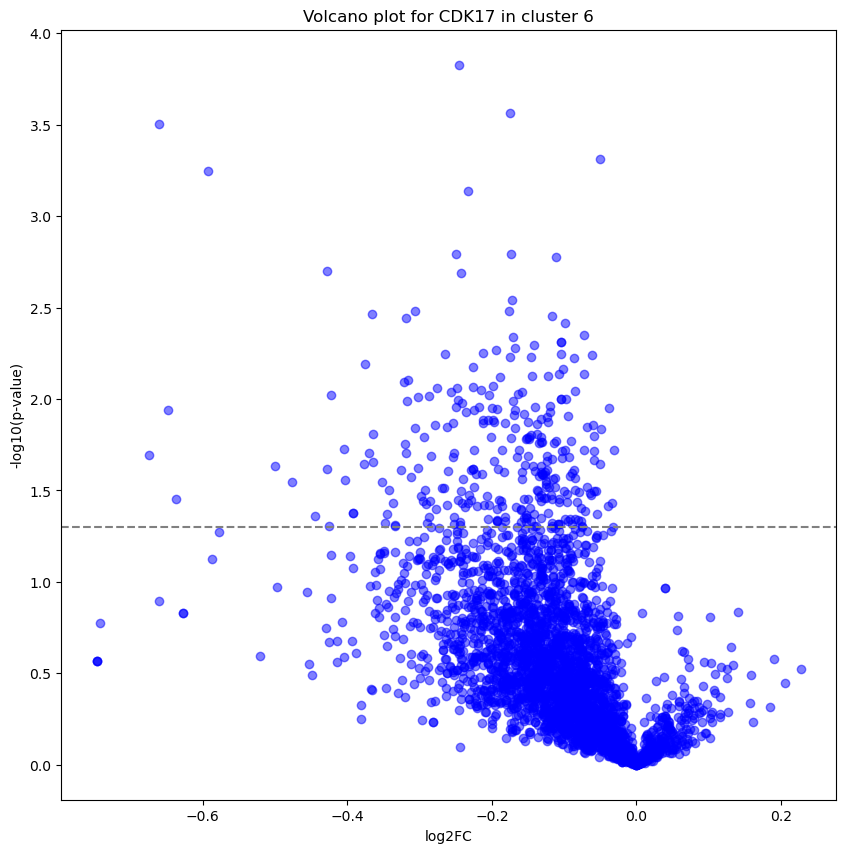

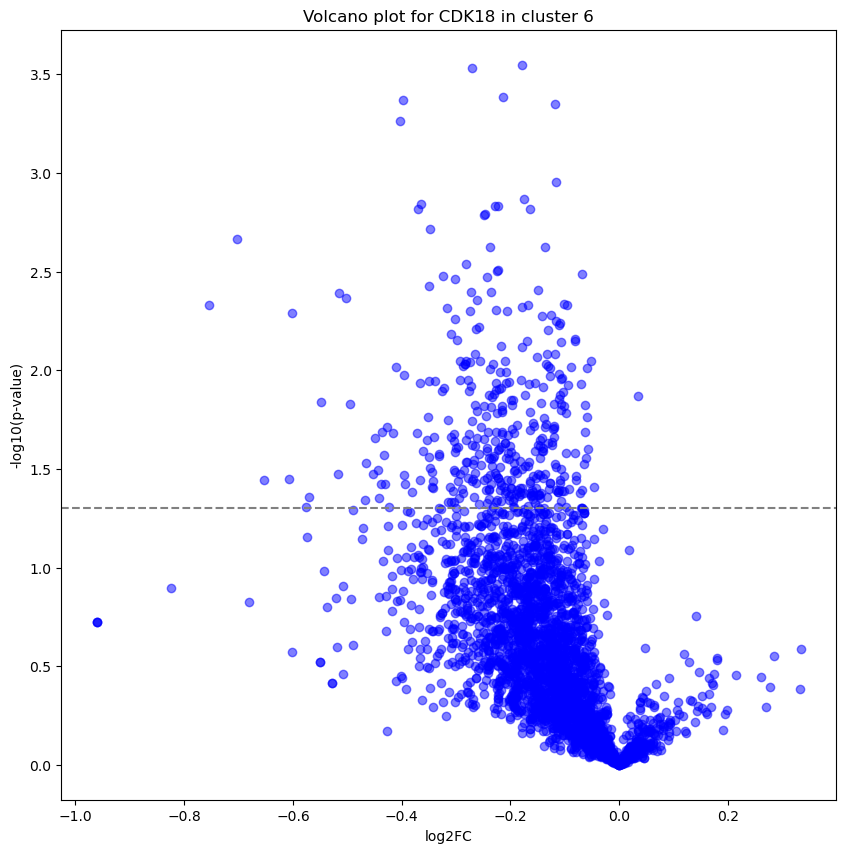

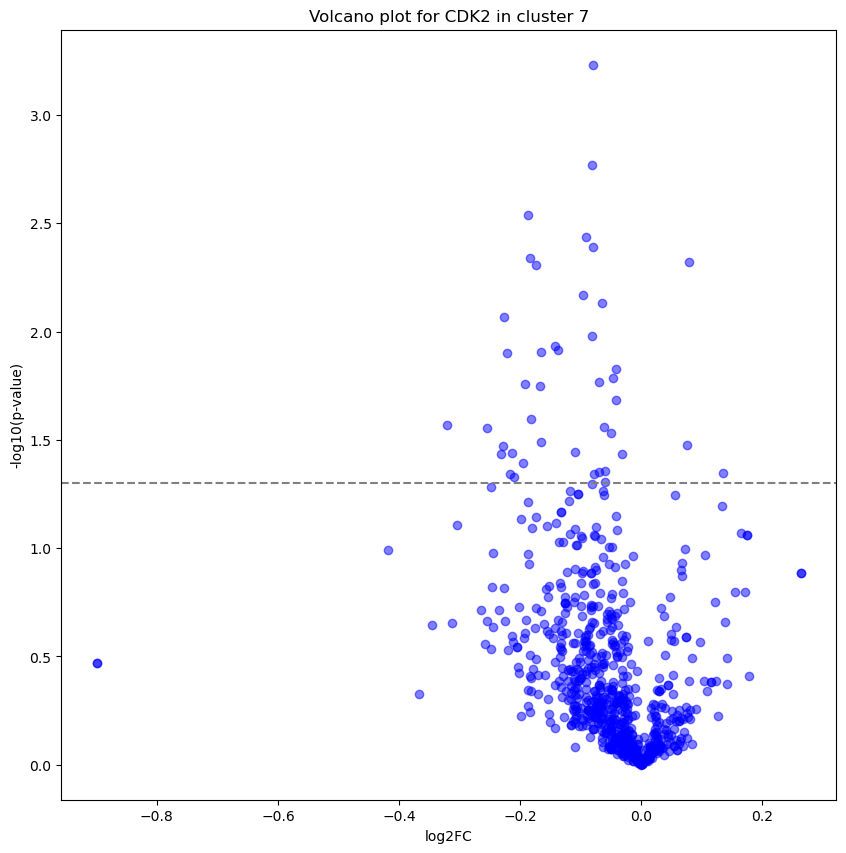

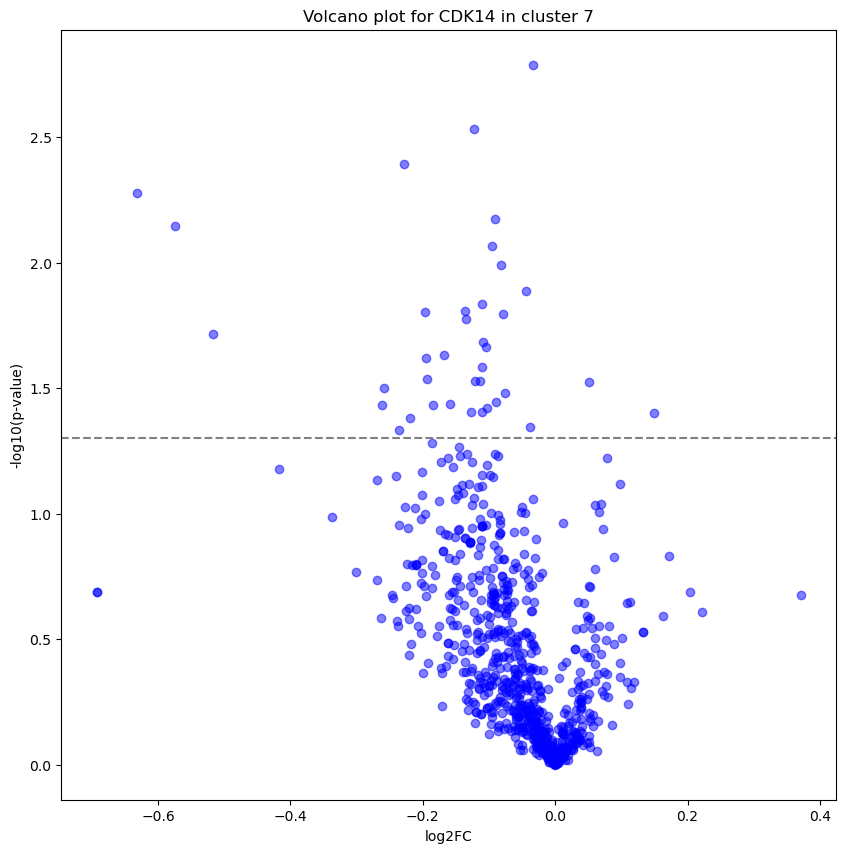

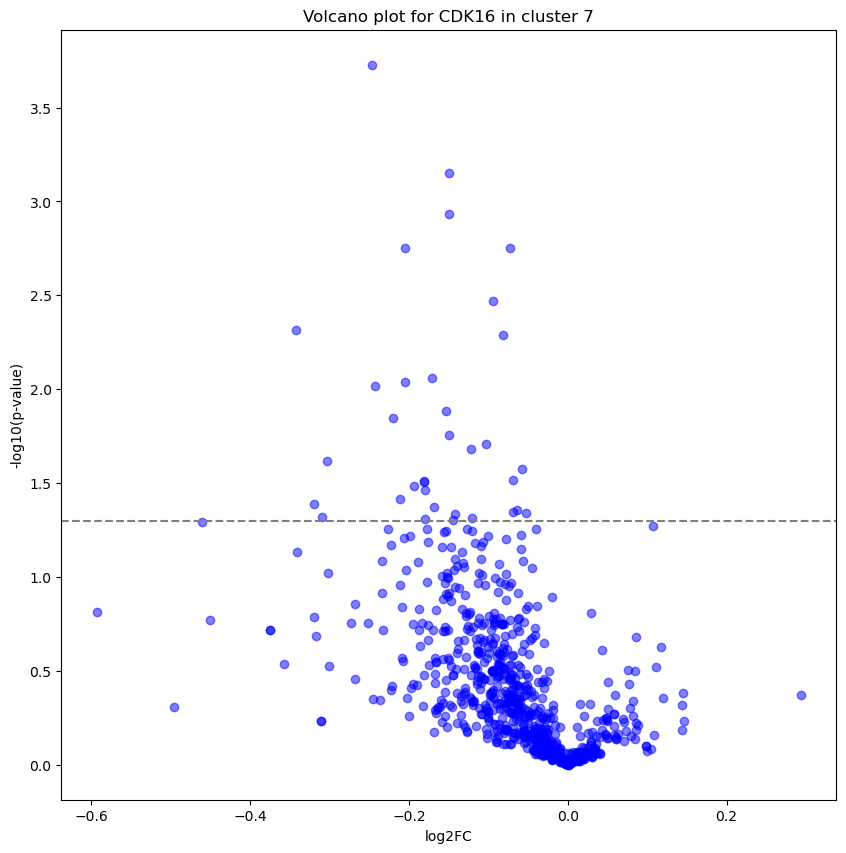

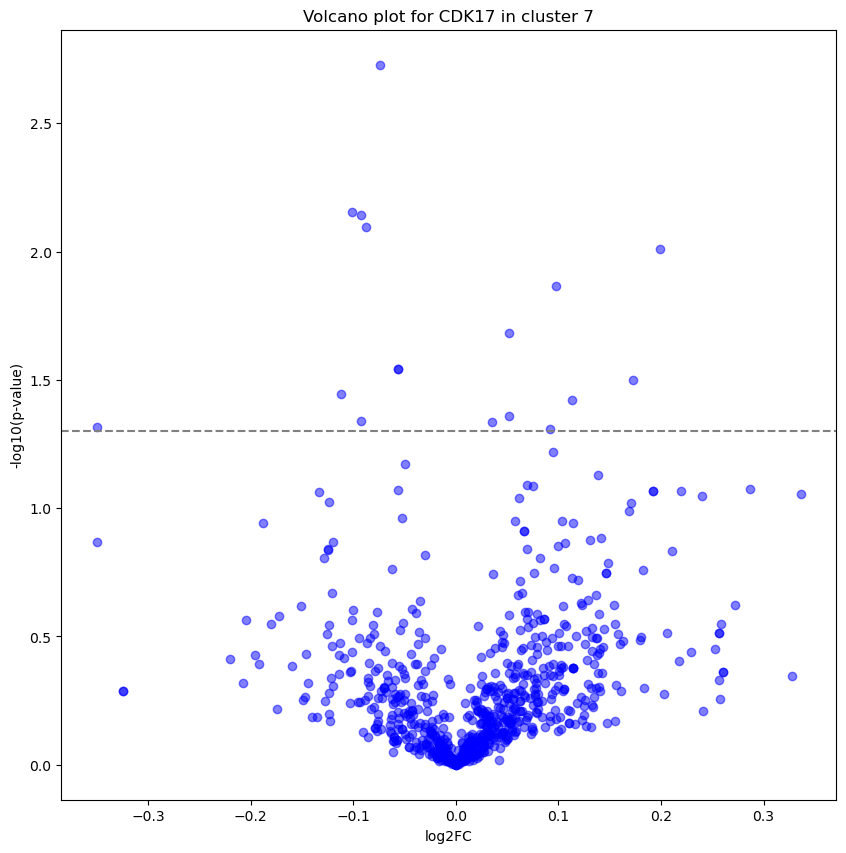

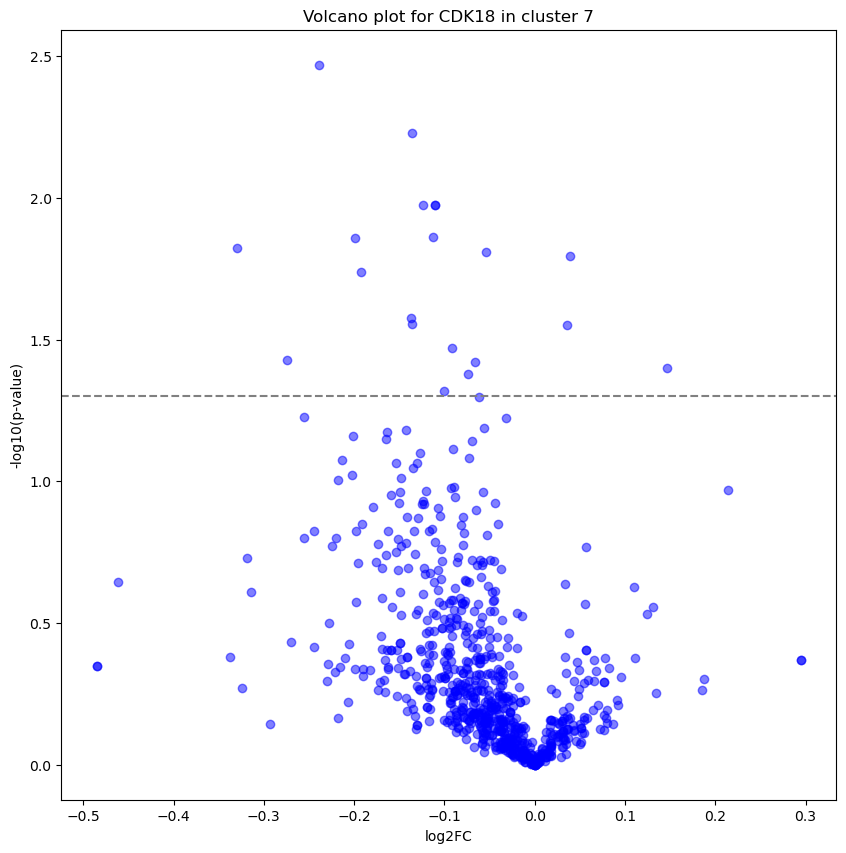

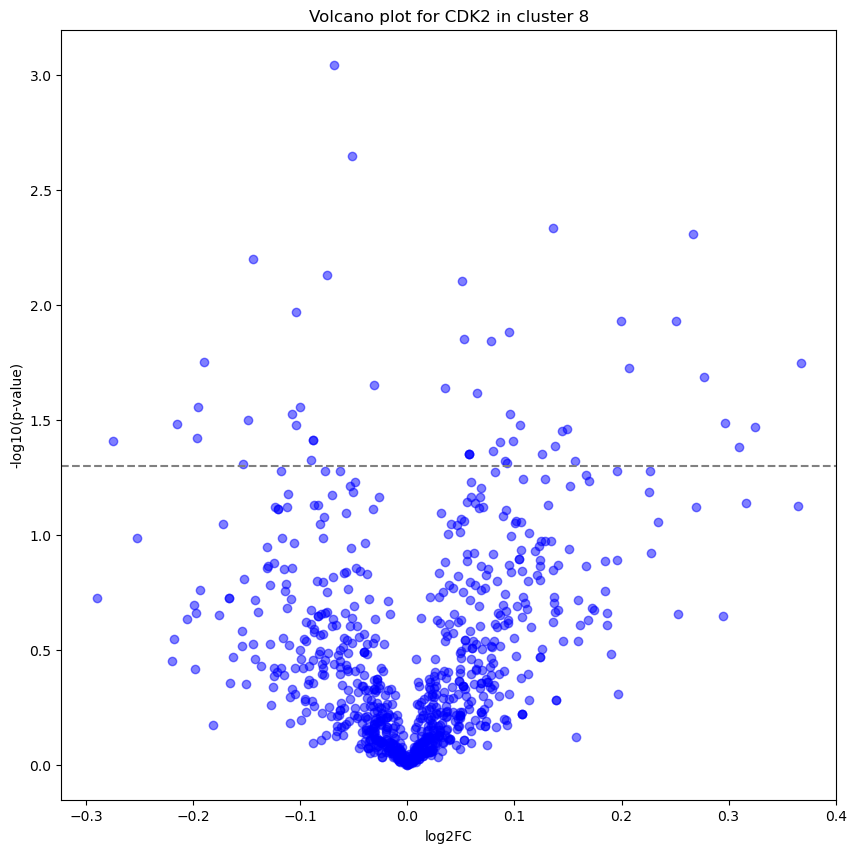

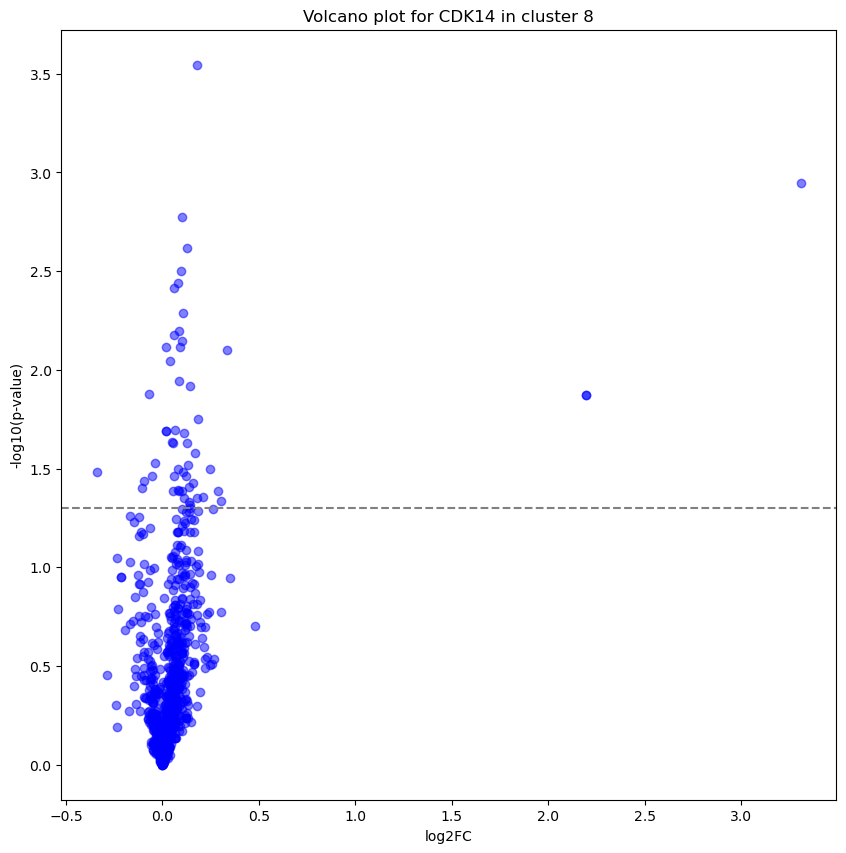

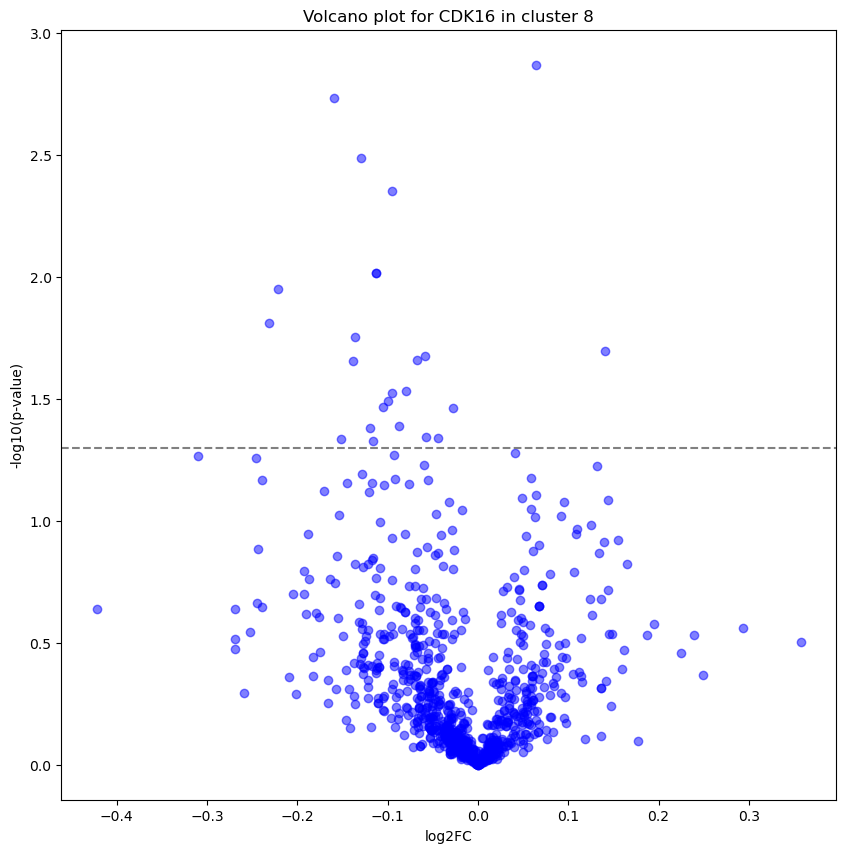

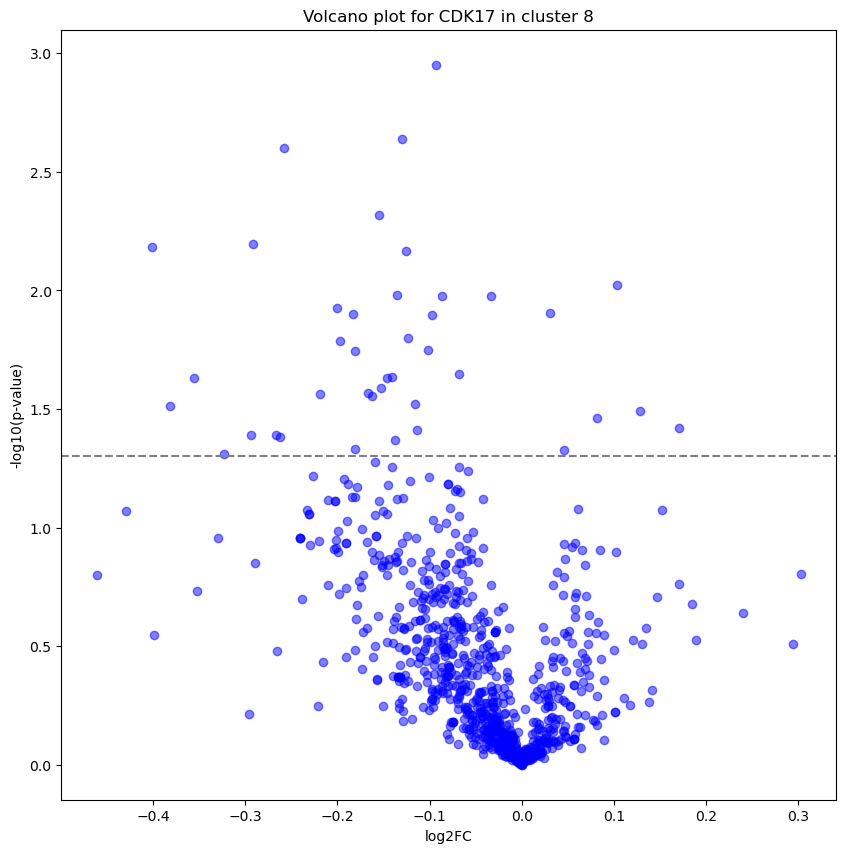

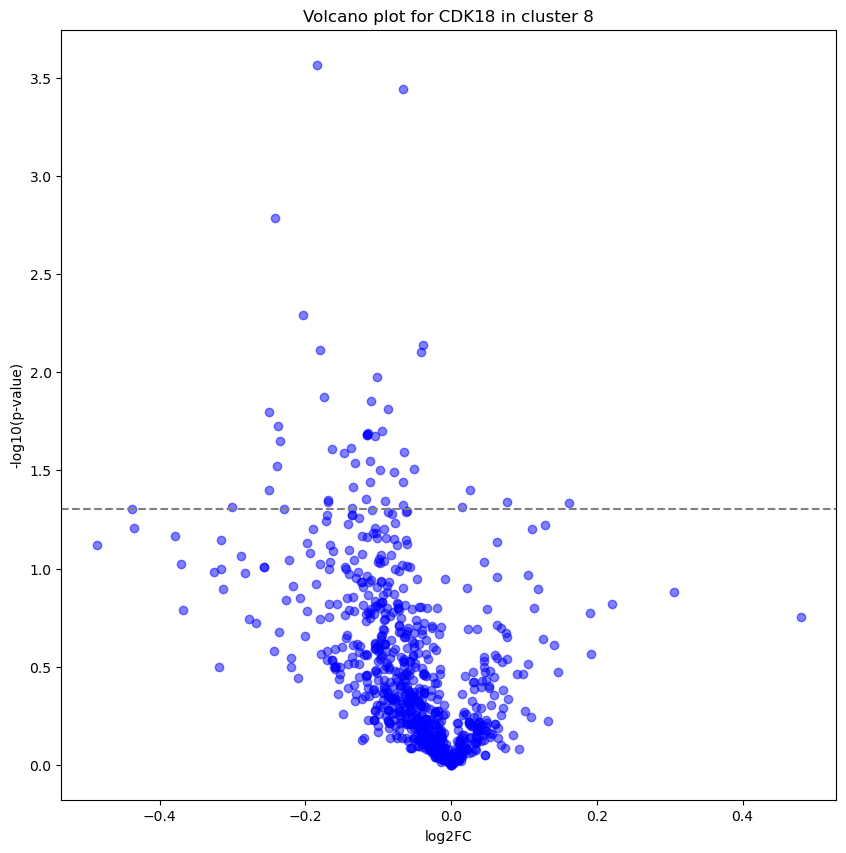

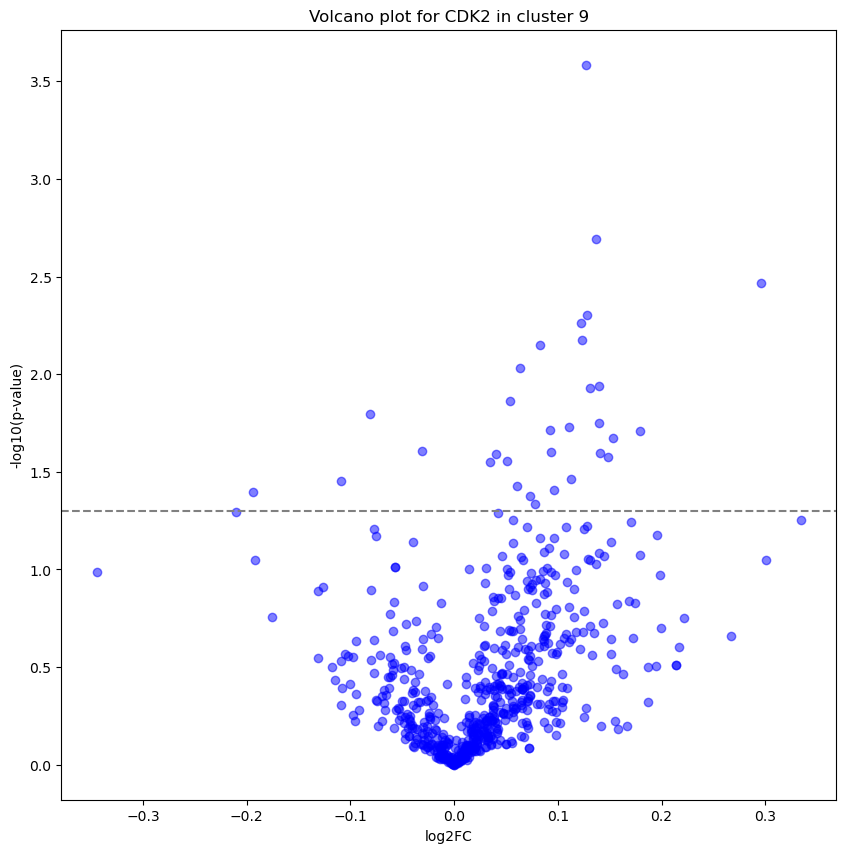

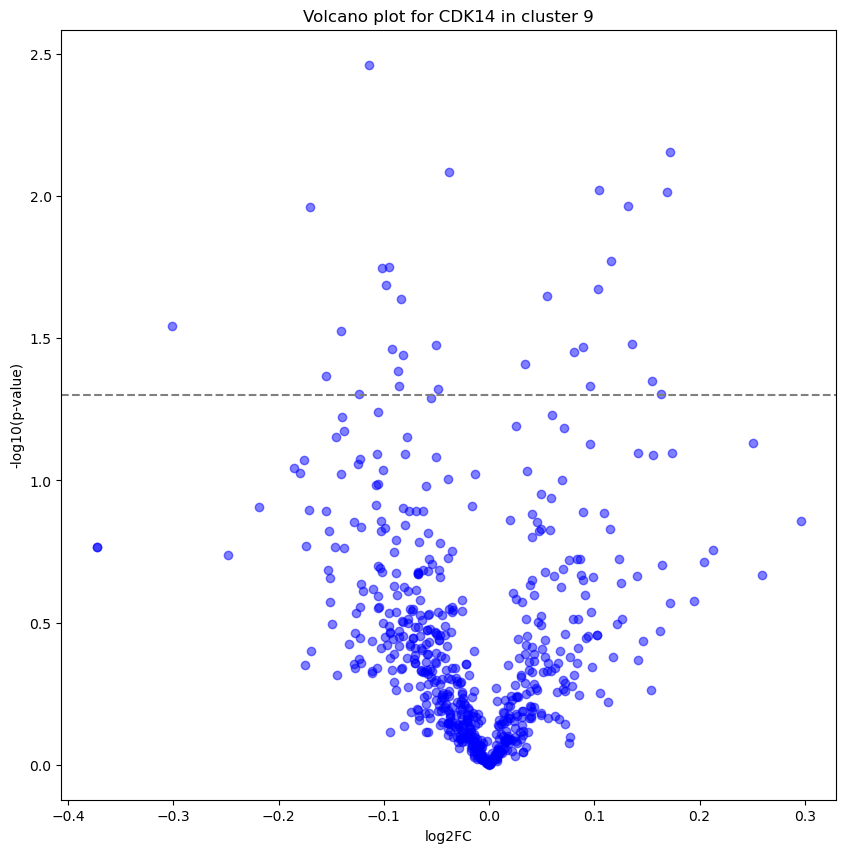

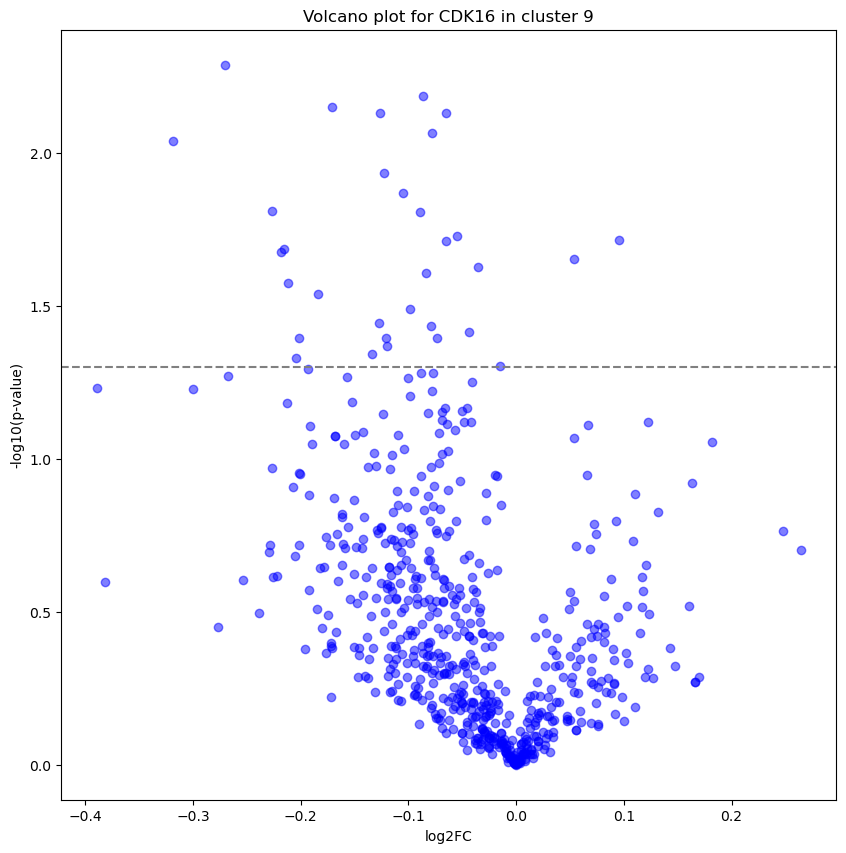

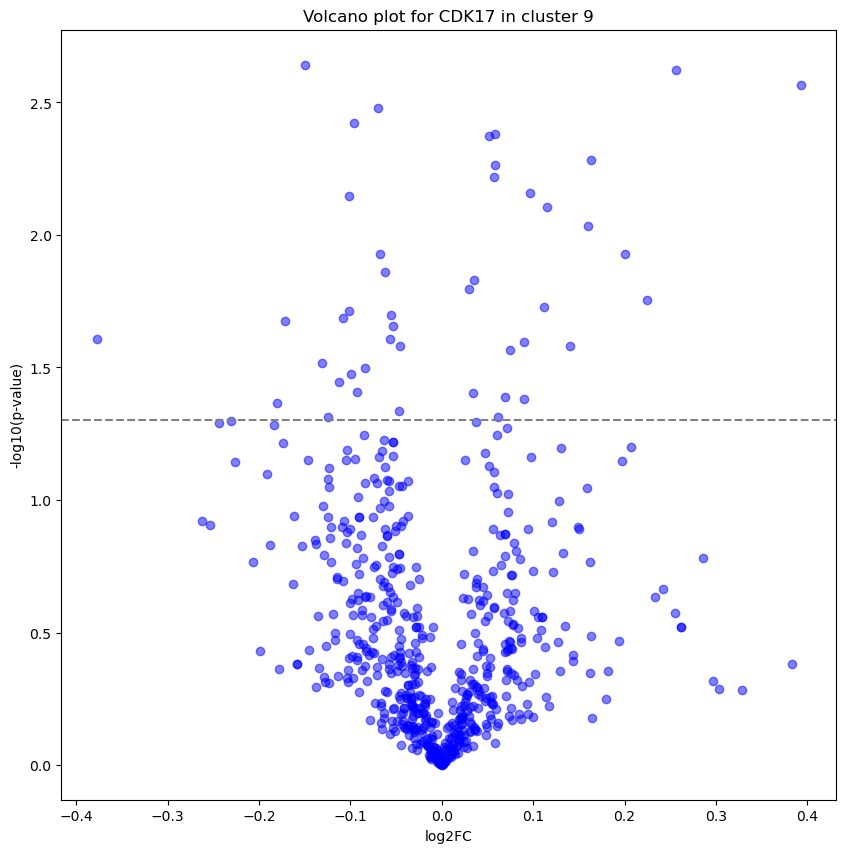

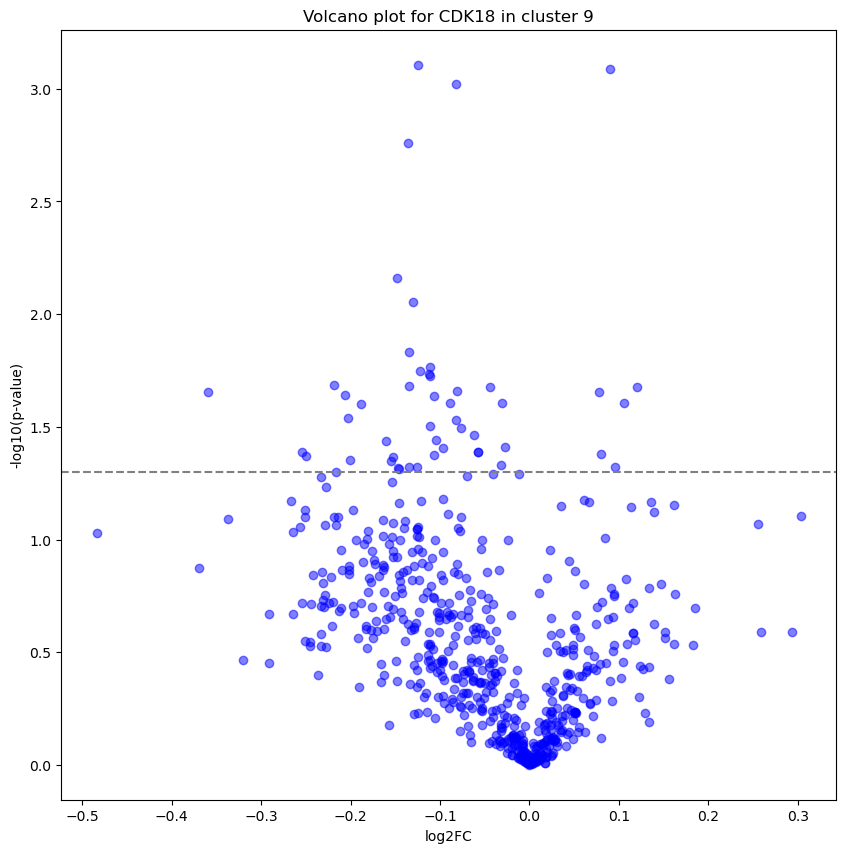

In [26]:
# I now want to make a volcano plot for each cluster and condition

# Make a list of the clusters
clusters = list(set(corr_clusters))

# Already have the comparisons dict

for cluster in clusters:
    for key in comparisons.keys():
        # Make a volcano plot
        fig, ax = plt.subplots(figsize=(10,10))
        # Use default colors for the clusters
        # Color the points on the volcano plot by cluster - use  the colors list
        # Don't do it with the for loop because it affects the order of the points
        scatter = ax.scatter(combined_zscore_with_fc['log2FC_' + key][combined_zscore_with_fc['cluster'] == cluster], -np.log10(combined_zscore_with_fc['pval_' + key][combined_zscore_with_fc['cluster'] == cluster]), c='blue', alpha=0.5)

        
        # Add a line for a significance threshold
        ax.axhline(y=-np.log10(0.05), color='grey', linestyle='--')

        ax.set_xlabel('log2FC')
        ax.set_ylabel('-log10(p-value)')
        ax.set_title('Volcano plot for ' + key + ' in cluster ' + str(cluster))
        fig.savefig(output_folder_path + 'cluster_' + str(cluster) + '_' + key + '_volcano.png')

In [27]:
# Lets further process the clusters...

#Make a dict to store the results
cluster_results = {}

# Iterate through each of the clusters
for cluster in clusters:
    # Filter the combined_zscore_with_fc dataframe to only include the current cluster
    cluster_df = combined_zscore_with_fc[combined_zscore_with_fc['cluster'] == cluster]
    # Get the protein names from the cluster_df
    names = list(set(cluster_df['Gene names']))

    # Remove NaNs from the names list
    names = [name for name in names if str(name) != 'nan']

    # Print the number of rows in the cluster_df
    print('Number of rows in cluster ' + str(cluster) + ': ' + str(len(cluster_df)))
    # Print the number of unique protein names in the cluster_df
    print('Number of unique protein names in cluster ' + str(cluster) + ': ' + str(len(names)))

    # Take the  first item in the names list
    first_names = [name.split(';')[0] for name in names]

    # Add info to the cluster_results dict
    cluster_results[cluster] = first_names

    # Write the list to a txt file
    with open(output_folder_path + 'cluster_' + str(cluster) + '_names.txt', 'w') as f:
        for name in first_names:
            f.write("%s\n" % name)

Number of rows in cluster 1: 831
Number of unique protein names in cluster 1: 589
Number of rows in cluster 2: 379
Number of unique protein names in cluster 2: 302
Number of rows in cluster 3: 810
Number of unique protein names in cluster 3: 608
Number of rows in cluster 4: 366
Number of unique protein names in cluster 4: 311
Number of rows in cluster 5: 806
Number of unique protein names in cluster 5: 607
Number of rows in cluster 6: 3357
Number of unique protein names in cluster 6: 1837
Number of rows in cluster 7: 780
Number of unique protein names in cluster 7: 602
Number of rows in cluster 8: 840
Number of unique protein names in cluster 8: 618
Number of rows in cluster 9: 635
Number of unique protein names in cluster 9: 485


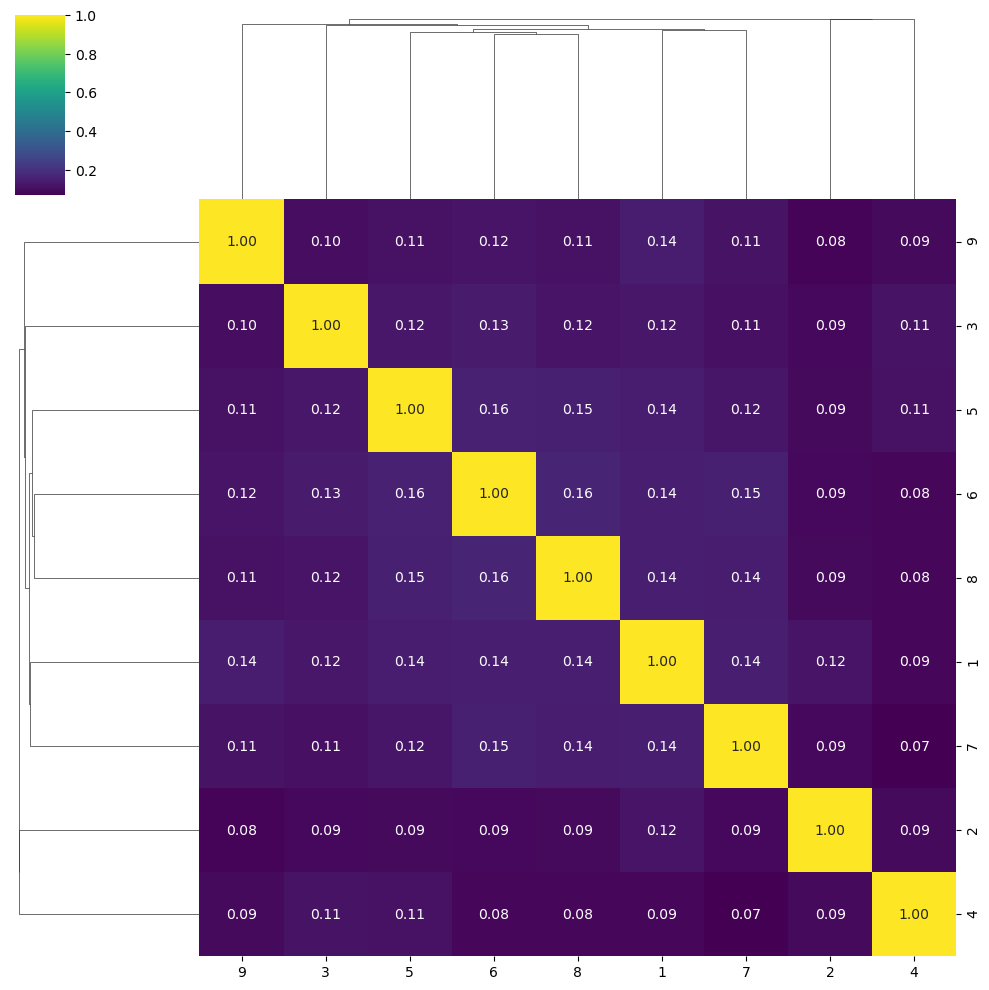

In [28]:
# I want to now make a jaccard index matrix for the clusters

# Make a np matrix to store the results
jaccard_matrix = np.zeros((len(clusters),len(clusters)))

# Iterate through each of the clusters
for i in range(len(clusters)):
    for j in range(len(clusters)):
        # Get the names for the current cluster
        names_i = cluster_results[clusters[i]]
        # Get the names for the current cluster
        names_j = cluster_results[clusters[j]]
        # Compute the jaccard index for the two clusters
        jaccard_matrix[i,j] = len(set(names_i).intersection(names_j)) / len(set(names_i).union(names_j))

# Make a dataframe from the jaccard matrix
jaccard_df = pd.DataFrame(jaccard_matrix, index=clusters, columns=clusters)

# Create a clustermap of the jaccard index matrix
g = sns.clustermap(jaccard_df, cmap='viridis', figsize=(10,10), annot=True, fmt='.2f')
g.savefig(output_folder_path + 'jaccard_index_clustermap.png')

In [29]:
# Save the correlation matrix to a csv file
corr.to_csv(output_folder_path + 'correlation_matrix.csv')

In [31]:
# Now time to integrate with the proximity data
prox = pd.read_csv(proximity_file_name)
prox

Experiment.ID  First.Prey.GeneID Bait.Gene.Name    Bait  \
0       NES-mT-KL-60m-Rapi                NaN            NaN   IDGT6   
1       NES-mT-KL-60m-Rapi                NaN            NaN   IDGT6   
2         mT-NES-2hrB-Rapi                NaN            NaN   IDGT6   
3         mT-NES-2hrB-Rapi                NaN            NaN   IDGT6   
4               CUL3-mT-IB            57563.0           CUL3  Q13618   
...                    ...                ...            ...     ...   
348404        mT-CDK2-2hrB             8562.0           CDK2  P24941   
348405       PSKH2-mT-30mB            63967.0          PSKH2  Q96QS6   
348406       PSKH2-mT-30mB            64682.0          PSKH2  Q96QS6   
348407       PSKH2-mT-30mB             7272.0          PSKH2  Q96QS6   
348408       PSKH2-mT-30mB             9943.0          PSKH2  Q96QS6   

       First.Bait.Uniprot Canonical.First.Bait.Uniprot Bait.Gene.Synonym  \
0                   IDGT6                        IDGT6               NaN   
1                   IDGT6                        IDGT6               NaN   
2                   IDGT6                        IDGT6               NaN   
3                   IDGT6                        IDGT6               NaN   
4                  Q13618                       Q13618          KIAA0617   
...                   ...                          ...               ...   
348404             P24941                       P24941             CDKN2   
348405             Q96QS6                       Q96QS6               NaN   
348406             Q96QS6                       Q96QS6               NaN   
348407             Q96QS6                       Q96QS6               NaN   
348408             Q96QS6                       Q96QS6               NaN   

       Bait.GeneID  boosted_by Prey.Gene.Name  ... kinase_com_name class_2019  \
0              NaN         NaN            NaN  ...             NaN        NaN   
1              NaN         NaN            NaN  ...             NaN        NaN   
2              NaN         NaN            NaN  ...             NaN        NaN   
3              NaN         NaN            NaN  ...             NaN        NaN   
4             8452         NaN          KLHL8  ...             NaN        NaN   
...            ...         ...            ...  ...             ...        ...   
348404        1017         NaN           DENR  ...             NaN        NaN   
348405       85481         NaN          CLSPN  ...             NaN        NaN   
348406       85481         NaN         ANAPC1  ...             NaN        NaN   
348407       85481         NaN            TTK  ...             TTK      Light   
348408       85481         NaN          OXSR1  ...            OSR1      Light   

       is_Bait BaitGene in.BioGRID  Evidence.Weight  \
0         True      NaN      False              NaN   
1         True    IDGT6      False              NaN   
2         True      NaN      False              NaN   
3         True    IDGT6      False              NaN   
4        False     CUL3       True              6.0   
...        ...      ...        ...              ...   
348404   False     CDK2      False              NaN   
348405   False    PSKH2      False              NaN   
348406   False    PSKH2      False              NaN   
348407   False    PSKH2      False              NaN   
348408   False    PSKH2      False              NaN   

                                     Experimental.Systems  \
0                                                     NaN   
1                                                     NaN   
2                                                     NaN   
3                                                     NaN   
4       Affinity Capture-MS;Affinity Capture-MS;Affini...   
...                                                   ...   
348404                                                NaN   
348405                                                NaN   
348406                                              

In [37]:
# Subset the proximity data for each comparison using the gene name of the comparison
bait_data = {}

for key in comparisons.keys():
    # Subset the proximity data for the gene names
    prox_subset = prox[prox['Bait.Gene.Name'] == key]
    # Write the proximity data to a csv file
    bait_data[key] = prox_subset

# Now I want to define a function that takes in a gene name and a bait name and returns the SaintScore for that bait-gene pair using the bait_data dict

def get_saint_score(gene_name, bait_name):
    # Get the bait data for the current bait
    bait_df = bait_data[bait_name]
    # Get the saint score for the current gene
    saint_score = bait_df[bait_df['Prey.Gene.Name'] == gene_name]['SaintScore']
    # Check if the saint score is empty
    if len(saint_score) == 0:
        return 0
    else:
        return saint_score.values[0]
    
# Now I want to add a column to the combined_zscore_with_fc dataframe for each bait that contains the saint score for that bait-gene pair
for key in bait_data:
    combined_zscore_with_fc['SaintScore_' + key] = combined_zscore_with_fc['Gene names'].apply(lambda x: get_saint_score(x, key))

In [38]:
# Write the combined_zscore_with_fc dataframe to a csv file
combined_zscore_with_fc.to_csv(output_folder_path + 'combined_with_saint_scores.csv')

Proteins Positions within proteins Leading proteins Protein  \
index                                                                      
E2F8_S102      A0AVK6                       102           A0AVK6  A0AVK6   
ESYT2_S755     A0FGR8                       755           A0FGR8  A0FGR8   
ESYT2_S758     A0FGR8                       758           A0FGR8  A0FGR8   
ESYT2_S761     A0FGR8                       761           A0FGR8  A0FGR8   
ESYT2_S739     A0FGR8                       739           A0FGR8  A0FGR8   
...               ...                       ...              ...     ...   
TJP2_Y932      Q9UDY2                       932           Q9UDY2  Q9UDY2   
WBP11_Y236     Q9Y2W2                       236           Q9Y2W2  Q9Y2W2   
SUPT16H_Y701   Q9Y5B9                       701           Q9Y5B9  Q9Y5B9   
MMP24_Y170     Q9Y5R2                       170           Q9Y5R2  Q9Y5R2   
MMP24_Y175     Q9Y5R2                       175           Q9Y5R2  Q9Y5R2   

                                                  Protein names Gene names  \
index                                                                        
E2F8_S102                             Transcription factor E2F8       E2F8   
ESYT2_S755                             Extended synaptotagmin-2      ESYT2   
ESYT2_S758                             Extended synaptotagmin-2      ESYT2   
ESYT2_S761                             Extended synaptotagmin-2      ESYT2   
ESYT2_S739                             Extended synaptotagmin-2      ESYT2   
...                                                         ...        ...   
TJP2_Y932                           Tight junction protein ZO-2       TJP2   
WBP11_Y236                         WW domain-binding protein 11      WBP11   
SUPT16H_Y701                         FACT complex subunit SPT16    SUPT16H   
MMP24_Y170    Matrix metalloproteinase-24;Processed matrix m...      MMP24   
MMP24_Y175    Matrix metalloproteinase-24;Processed matrix m...      MMP24   

                                                  Fasta headers  \
index                                                             
E2F8_S102     sp|A0AVK6|E2F8_HUMAN Transcription factor E2F8...   
ESYT2_S755    sp|A0FGR8|ESYT2_HUMAN Extended synaptotagmin-2...   
ESYT2_S758    sp|A0FGR8|ESYT2_HUMAN Extended synaptotagmin-2...   
ESYT2_S761    sp|A0FGR8|ESYT2_HUMAN Extended synaptotagmin-2...   
ESYT2_S739    sp|A0FGR8|ESYT2_HUMAN Extended synaptotagmin-2...   
...                                                         ...   
TJP2_Y932     sp|Q9UDY2|ZO2_HUMAN Tight junction protein ZO-...   
WBP11_Y236    sp|Q9Y2W2|WBP11_HUMAN WW domain-binding protei...   
SUPT16H_Y701  sp|Q9Y5B9|SP16H_HUMAN FACT complex subunit SPT...   
MMP24_Y170    sp|Q9Y5R2|MMP24_HUMAN Matrix metalloproteinase...   
MMP24_Y175    sp|Q9Y5R2|MMP24_HUMAN Matrix metalloproteinase...   

              Localization prob  Score diff           PEP  ...  log2FC_CDK17  \
index                                                      ...                 
E2F8_S102              1.000000    109.7930  9.665900e-05  ...      0.166987   
ESYT2_S755             0.852546     10.4747  2.359760e-08  ...     -0.061328   
ESYT2_S758             0.998529     28.5275  1.523980e-48  ...     -0.055753   
ESYT2_S761             0.999958     44.7455  1.954520e-15  ...     -0.128935   
ESYT2_S739             0.888719     10.1293  2.057160e-28  ...     -0.068306   
...                         ...         ...           ...  ...           ...   
TJP2_Y932              0.777168      5.4237  1.227290e-51  ...     -0.112508   
WBP11_Y236             0.949408     12.7337  3.157370e-03  ...     -0.012551   
SUPT16H_Y701           0.999891     42.6206  1.762720e-02  ...      0.047754   
MMP24_Y170             1.000000     45.4342  3.280980e-02  ...     -0.051704   
MMP24_Y175             1.000000     45.4342  3.280980e-02  ...     -0.051704   

              pval_CDK17  log2FC_CDK18  pval_CDK18  cluster  SaintScore_CDK2  \
index           

In [42]:
# Set the thresholds
p_value_threshold = 0.05
log2_fold_change_threshold = 0.5
saint_score_threshold = 0.7

# Create an empty dictionary to store the lists of substrates for each kinase
substrates = {}

# Iterate over each kinase in the comparisons dictionary
for kinase in comparisons.keys():
    # Filter the combined_zscore_with_fc dataframe based on the thresholds
    filtered_df = combined_zscore_with_fc[(combined_zscore_with_fc['pval_' + kinase] < p_value_threshold) &
                                          (combined_zscore_with_fc['log2FC_' + kinase] > log2_fold_change_threshold) &
                                          (combined_zscore_with_fc['SaintScore_' + kinase] > saint_score_threshold)]
    
    # Get the list of substrates for the current kinase
    substrate_list = filtered_df['Gene names'].tolist()
    
    # Add the list of substrates to the substrates dictionary
    substrates[kinase] = substrate_list

# Print the lists of substrates for each kinase
for kinase, substrate_list in substrates.items():
    print(f"Substrates for {kinase}: {substrate_list}")


Substrates for CDK2: ['XRCC6', 'CBS', 'SRRT']
Substrates for CDK14: ['CDK14', 'CDK14', 'CDK14']
Substrates for CDK16: ['IRS4', 'EPB41L2', 'CDK16', 'CDK16', 'CDK16', 'CDK16', 'CDK16', 'CDK16', 'CDK16', 'CDK16', 'AHNAK', 'OCLN', 'CDK16', 'SCRIB']
Substrates for CDK17: ['CDK17', 'CDK17', 'CDK17', 'PRRC2B', 'PRRC2B']
Substrates for CDK18: ['DDX3X', 'MAP4', 'MAP1B', 'RANBP2', 'CDK18', 'CDK18', 'CDK18', 'CDK18', 'CDK18', 'CDK18', 'CDK18', 'CDK18', 'GRSF1']


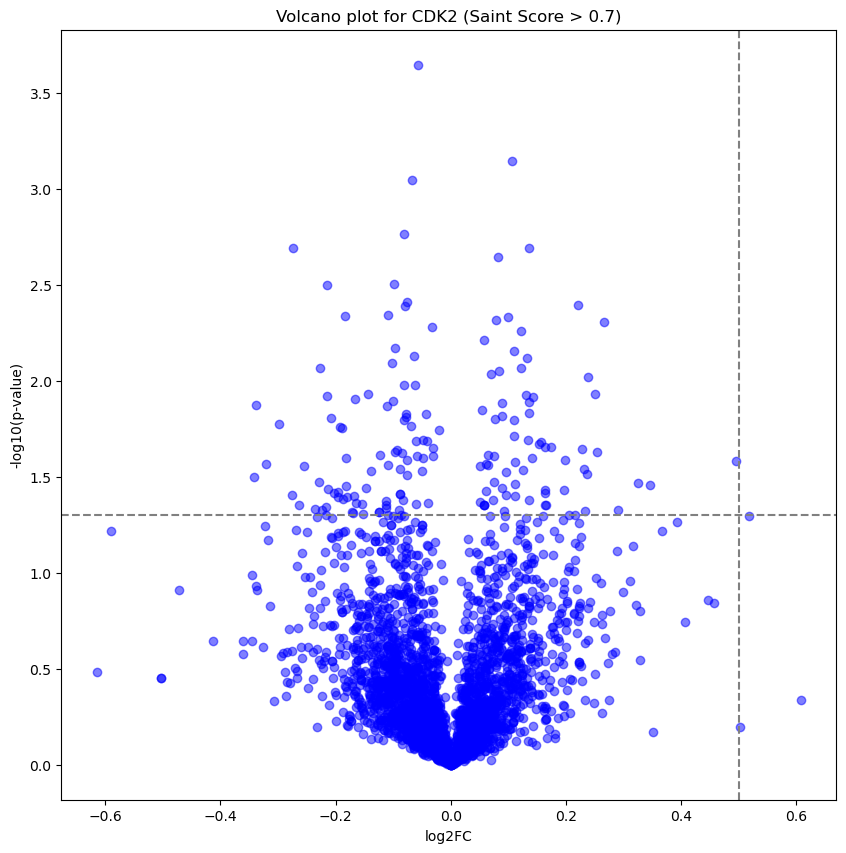

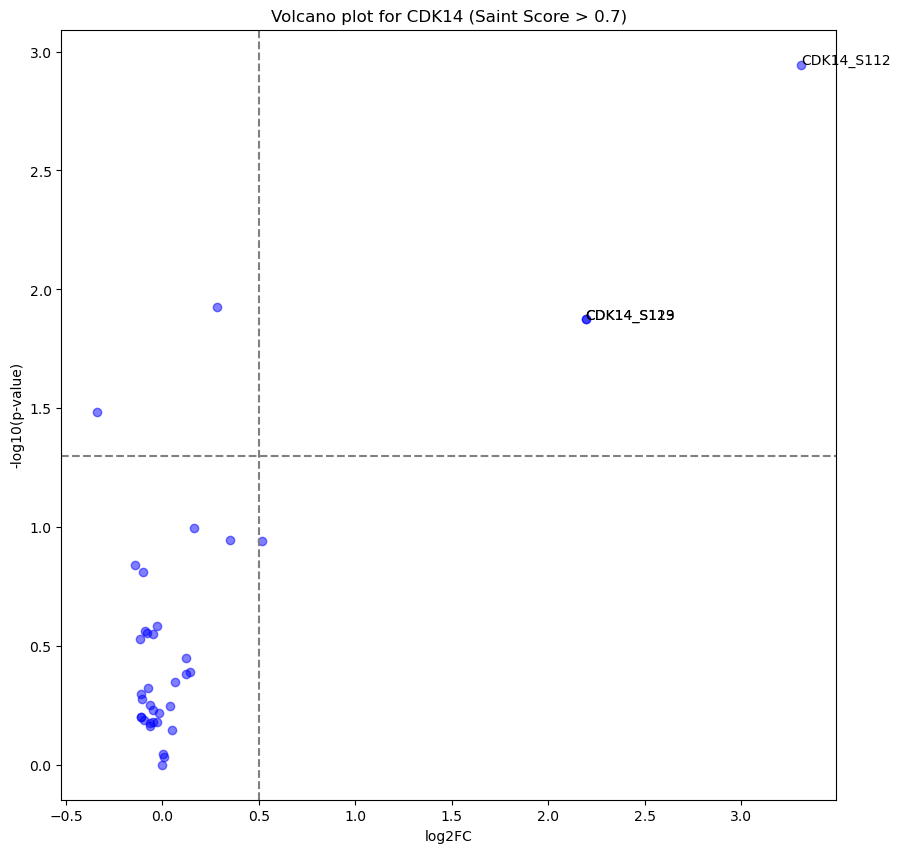

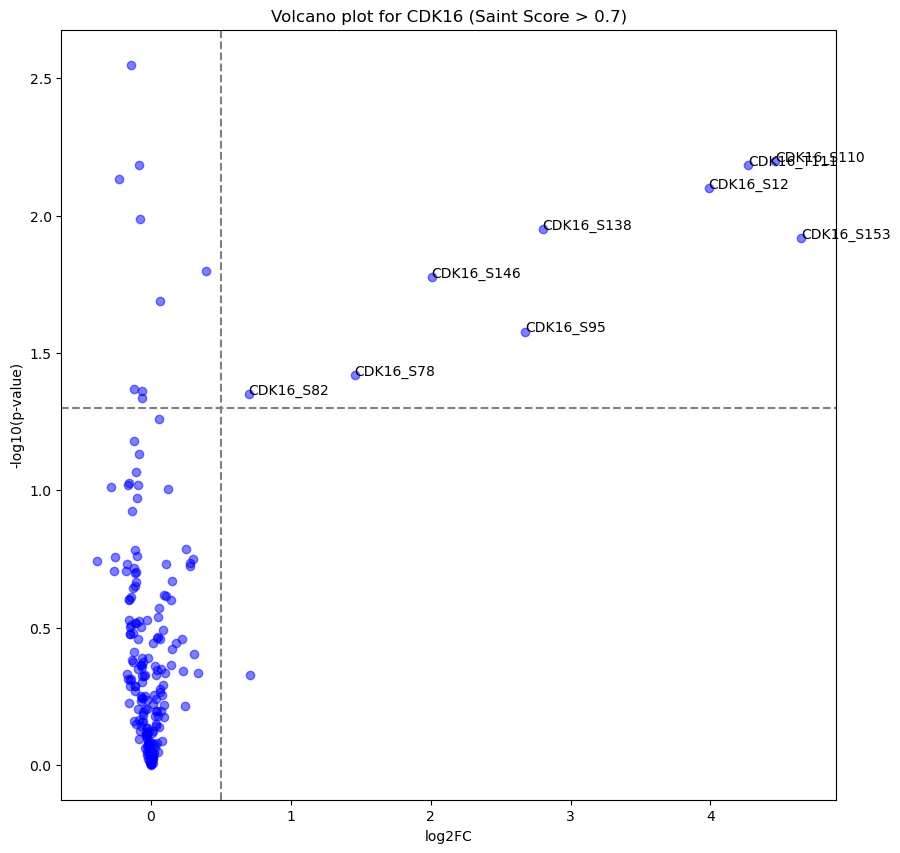

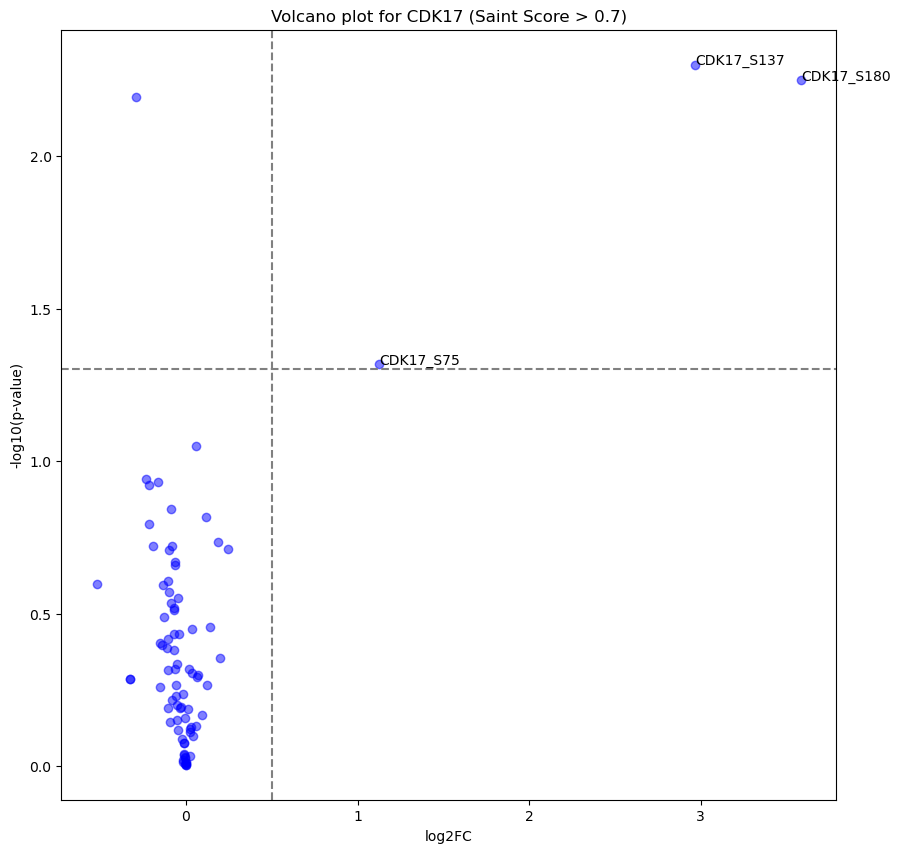

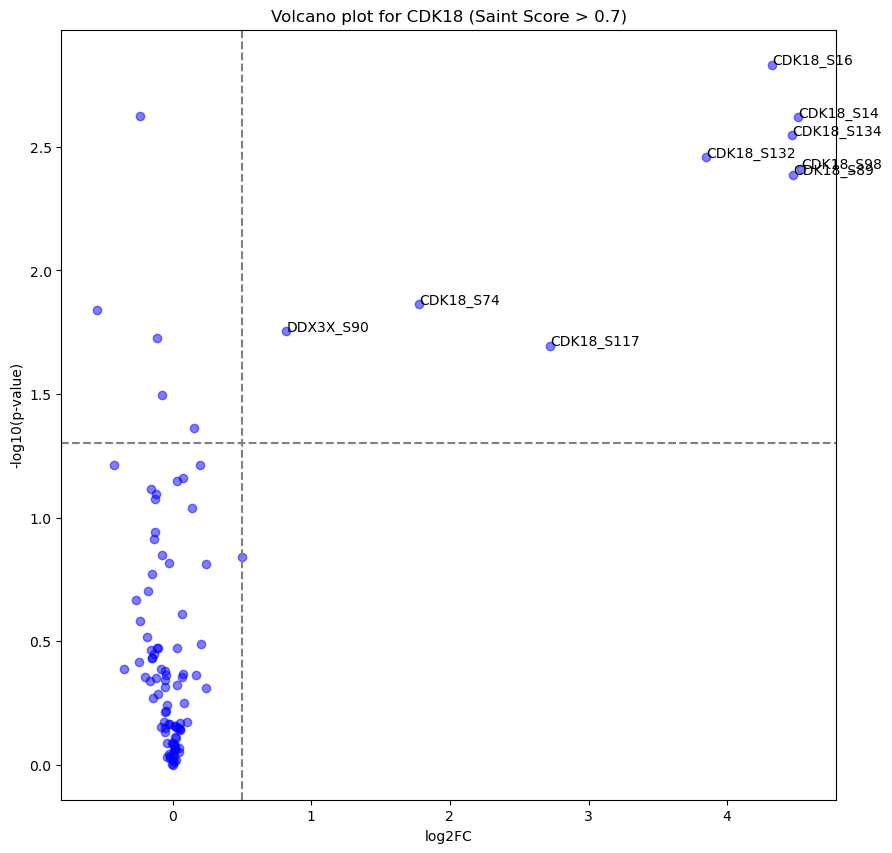

In [44]:
import matplotlib.pyplot as plt

# Set the saint score threshold
saint_score_threshold = 0.7

# Iterate over each comparison in the comparisons dictionary
for key in comparisons.keys():
    # Filter the combined_zscore_with_fc dataframe based on the saint score threshold
    filtered_df = combined_zscore_with_fc[combined_zscore_with_fc['SaintScore_' + key] > saint_score_threshold]
    
    # Create a volcano plot for the filtered data
    fig, ax = plt.subplots(figsize=(10, 10))
    scatter = ax.scatter(filtered_df['log2FC_' + key], -np.log10(filtered_df['pval_' + key]), c='blue', alpha=0.5)
    
    # Add a line for a significance threshold
    ax.axhline(y=-np.log10(0.05), color='grey', linestyle='--')

    # Add a line for the log2FC threshold
    ax.axvline(x=0.5, color='grey', linestyle='--')

    # Add text annotations for all points that are significant and have a log2FC greater than 0.5
    for i, txt in enumerate(filtered_df.index):
        if filtered_df['pval_' + key][i] < 0.05 and filtered_df['log2FC_' + key][i] > 0.5:
            ax.annotate(txt, (filtered_df['log2FC_' + key][i], -np.log10(filtered_df['pval_' + key][i])))

    
    ax.set_xlabel('log2FC')
    ax.set_ylabel('-log10(p-value)')
    ax.set_title('Volcano plot for ' + key + ' (Saint Score > ' + str(saint_score_threshold) + ')')
    
    # fig.savefig(output_folder_path + key + '_volcano_filtered.png')


In [38]:
# Make a GCT file for CDK17 signed pvals
acc = []
signed_pvals = []
for i in range(len(combined_zscore_with_fc)):
    first_protein = combined_zscore_with_fc['Proteins'][i].split(';')[0]
    first_resnum = combined_zscore_with_fc['Positions within proteins'][i].split(';')[0]
    first_res = combined_zscore_with_fc['Amino acid'][i]
    acc.append(first_protein + ';' + first_res + first_resnum + '-p')
    pval = combined_zscore_with_fc['pval_CDK17'][i]
    logfc = combined_zscore_with_fc['log2FC_CDK17'][i]
    if logfc > 0:
        pval = -1*pval
    else:
        pval = pval
    signed_pvals.append(pval)

# Make a dataframe from the acc and signed_pvals lists
df = pd.DataFrame({'id':acc,'PValue':signed_pvals})

# Write the dataframe to a gct file using tabs as the delimiter
df.to_csv(output_folder_path + 'CDK17_pvals_2.gct', sep='\t', index=False)

# Print the length of the dataframe
print('Length of dataframe: ' + str(len(df)))

Length of dataframe: 8804


In [19]:
# Read in the protein data

pg_path = txt_path + 'proteinGroups.txt'

pg = pd.read_csv(pg_path, sep='\t')
pg

/var/folders/zd/yf6hlh4n3q7_kq61v76mwb5r0000gn/T/ipykernel_74429/1682441323.py:5: DtypeWarning: Columns (122) have mixed types. Specify dtype option on import or set low_memory=False.
  pg = pd.read_csv(pg_path, sep='\t')


Protein IDs          Majority protein IDs  \
0                P0DPI2;A0A0B4J2D5             P0DPI2;A0A0B4J2D5   
1     P0DPI3;A0A0U1RRI6;A0A0U1RR11  P0DPI3;A0A0U1RRI6;A0A0U1RR11   
2                           A0AV96                        A0AV96   
3                           A0AVF1                        A0AVF1   
4                           A0AVK6                        A0AVK6   
...                            ...                           ...   
7947                   REV__Q9ULI3                   REV__Q9ULI3   
7948                   REV__Q9UM44                   REV__Q9UM44   
7949                   REV__Q9UPV0                   REV__Q9UPV0   
7950                   REV__Q9Y490                   REV__Q9Y490   
7951                   REV__Q9Y4K3                   REV__Q9Y4K3   

     Peptide counts (all) Peptide counts (razor+unique)  \
0                     9;9                           9;9   
1                   1;1;1                         1;1;1   
2                       3                             3   
3                       7                             7   
4                       1                             1   
...                   ...                           ...   
7947                    1                             1   
7948                    1                             1   
7949                    1                             1   
7950                    1                             1   
7951                    1                             1   

     Peptide counts (unique)                        Protein names Gene names  \
0                        9;9                                  NaN        NaN   
1                      1;1;1                                  NaN        NaN   
2                          3               RNA-binding protein 47      RBM47   
3                          7  Intraflagellar transport protein 56      TTC26   
4                          1            Transcription factor E2F8       E2F8   
...                      ...                                  ...        ...   
7947                       1                                  NaN        NaN   
7948                       1                                  NaN        NaN   
7949                       1                                  NaN        NaN   
7950                       1                                  NaN        NaN   
7951                       1                                  NaN        NaN   

                                          Fasta headers  Number of proteins  \
0     sp|P0DPI2|GAL3A_HUMAN Glutamine amidotransfera...                   2   
1     sp|P0DPI3|CENL2_HUMAN Centromere protein V-lik...                   3   
2     sp|A0AV96|RBM47_HUMAN RNA-binding protein 47 O...                   1   
3     sp|A0AVF1|IFT56_HUMAN Intraflagellar transport...                   1   
4     sp|A0AVK6|E2F8_HUMAN Transcription factor E2F8...                   1   
...                                                 ...                 ...   
7947  sp|Q9ULI3|HEG1_HUMAN Protein HEG homolog 1 OS=...                   1   
7948  sp|Q9UM44|HHLA2_HUMAN HERV-H LTR-associating p...                   1   
7949  sp|Q9UPV0|CE164_HUMAN Centrosomal protein of 1...                   1   
7950  sp|Q9Y490|TLN1_HUMAN Talin-1 OS=Homo sapiens O...                   1   
7951  sp|Q9Y4K3|TRAF6_HUMAN TNF receptor-associated ...                   1   

      Peptides  ...                                   Mod. peptide IDs  \
0            9  ...  15265;20510;24932;28159;34384;49888;51814;7590...   
1            1  ...                                              28983   
2            3  ...                            13145;65234;65235;75185   
3            7  ...             782;9367;10588;24978;28393;52579;60160   
4            1  ...                                               8665   
...        ...  ...                                                ...   
7947         1  ...                                              3252

In [29]:
# Create a copy of the pg dataframe
pg_copy = pg.copy()

# Change the column names according to the mapping
pg_copy.rename(columns=columns_mapping, inplace=True)

protein = 'CDK2'

# filter the protein dataframe to only include the protein of interest
protein_df = pg_copy[pg_copy['Gene names'] == protein]

# For each condition, make a list of the values
conditions = ['Ctrl','CDK2','CDK14','CDK16','CDK17','CDK18']

data = {}
for condition in conditions:
    data[condition] = []
    columns = [col for col in protein_df.columns if col.startswith(condition)]
    data[condition].append(protein_df[columns].values[0])


# Create a dataframe from the data
boxplot_df = pd.DataFrame(data)
# Log10 transform the data
boxplot_df = np.log10(boxplot_df + 1)

# Plot a bar graph instead
fig, ax = plt.subplots(figsize=(4,4))

# Make a bargraph with error lines
ax.bar(boxplot_df.columns, boxplot_df.mean(), yerr=boxplot_df.std())

# Remove gridlines
plt.grid(False)

plt.ylabel('Log10 Intensity')
plt.xlabel('Condition')
plt.title(protein + ' Boxplot')
plt.savefig(output_folder_path + protein + '_boxplot.png',dpi=300)




TypeError: loop of ufunc does not support argument 0 of type numpy.ndarray which has no callable log10 method

In [21]:
string = 'spice'

string.split(';')[0]

'spice'

Text(0.5, 1.0, 'Enrichment Scores for CDK17')

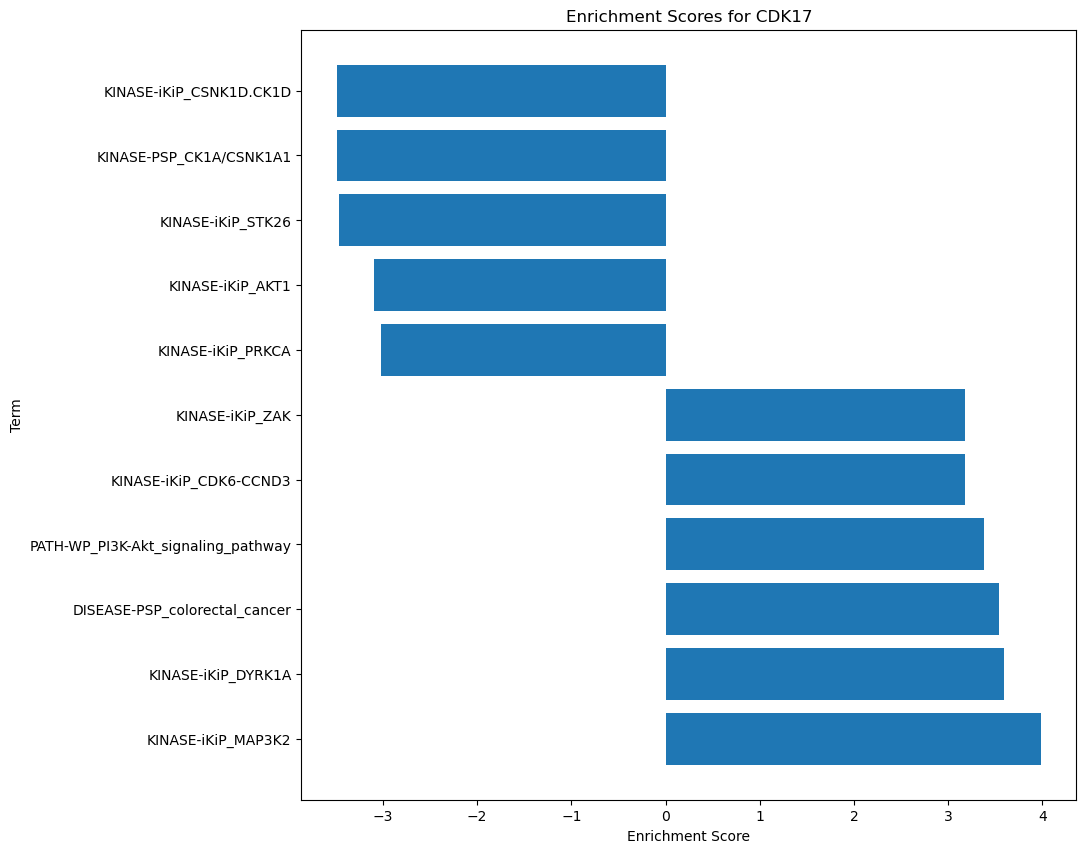

In [39]:
# Create a bar plot of terms and enrichment scores

terms = [
    'KINASE-iKiP_MAP3K2',
    'KINASE-iKiP_DYRK1A',
    'DISEASE-PSP_colorectal_cancer',
    'PATH-WP_PI3K-Akt_signaling_pathway',
    'KINASE-iKiP_CDK6-CCND3',
    'KINASE-iKiP_ZAK',
    'KINASE-iKiP_PRKCA',
    'KINASE-iKiP_AKT1',
    'KINASE-iKiP_STK26',
    'KINASE-PSP_CK1A/CSNK1A1',
    'KINASE-iKiP_CSNK1D.CK1D'
]

scores = [
    3.9854,
3.5932,
3.5403,
3.3782,
3.182,
3.175,
-3.0202,
-3.0958,
-3.4631,
-3.4869,
-3.4919
]

fig, ax = plt.subplots(figsize=(10,10))

# Make a bargraph horizontally to show positive and negative enrichment scores
ax.barh(terms, scores)

# Remove gridlines
plt.grid(False)

plt.xlabel('Enrichment Score')
plt.ylabel('Term')
plt.title('Enrichment Scores for CDK17')
